# VaR Estimation and Backtesting Using Historical, Jump Diffusion, and Rough Volatility Models

### Libraries and Packages

In [1]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde, norm, kurtosis
from fbm import FBM
from hurst import compute_Hc
import pandas_datareader.data as web
import datetime
import seaborn as sns

## Data

This block uses the `yfinance` library to download historical daily prices of the S&P 500 index from Yahoo Finance, covering the period from January 2006 to May 2025. The dataset is saved locally as a CSV file for reproducibility.

> ⚠️ Note: This step is not required to run the project, as the dataset (SP500_2006_2024.csv) is already included in the /DATA folder. In some environments, yfinance may fail to download data due to API limitations or connection issues. To ensure full reproducibility, the project uses the pre-downloaded file instead.

In [2]:
# Define ticker, dates and download data
ticker = "^GSPC"  # S&P 500
start_date = "2006-01-01"
end_date = "2025-05-07"

sp500_data = yf.download(ticker, start=start_date, end=end_date)

# Save CSV
sp500_data.to_csv("data/SP500_2006_2024.csv")

# Show first rows
print(sp500_data.head())
print(sp500_data.tail())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2006-01-03  1268.800049  1270.219971  1245.739990  1248.290039  2554570000
2006-01-04  1273.459961  1275.369995  1267.739990  1268.800049  2515330000
2006-01-05  1273.479980  1276.910034  1270.300049  1273.459961  2433340000
2006-01-06  1285.449951  1286.089966  1273.479980  1273.479980  2446560000
2006-01-09  1290.150024  1290.780029  1284.819946  1285.449951  2301490000
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2025-04-30  5569.060059  5581.839844  5433.240234  5499.439941  5449490000
2025-05-01  5604.140137  5658.910156  5597.350098  5625.140137  4935270000
2025-05-02  5686.669922  

This block loads a pre-cleaned CSV file containing historical price data for the S&P 500 index. The data was previously downloaded and stored locally to ensure consistency and reproducibility.

Here's what each step does:

- `read_csv(...)`: Loads the dataset from the specified file path.

- `rename(...)`: Renames the column "Price" to "Date". This assumes that during the cleaning process, the original date column may have been misnamed.

- `dropna(...)`: Removes any rows with missing values.

- `reset_index(...)`: Resets the index to ensure clean row ordering.

- `to_datetime(...)`: Converts the "Date" column from string to proper datetime format.

- `set_index(...)`: Sets the "Date" column as the index of the DataFrame for time series analysis.

> At the end of this step, sp500_data is a clean, indexed time series DataFrame ready for return and volatility computations.

In [3]:
sp500_data = pd.read_csv("data/SP500_2006_2024_clean.csv")
sp500_data.rename(columns={"Price": "Date"}, inplace=True)
sp500_data.dropna(inplace=True)

sp500_data.reset_index(drop=True, inplace=True)
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)


# Show first rows
print(sp500_data.head())
print(sp500_data.tail())

                         Close                High                 Low  \
Date                                                                     
2006-02-01     1282.4599609375  1283.3299560546875  1277.5699462890625   
2006-02-02  1270.8399658203125     1282.4599609375   1267.719970703125   
2006-02-03   1264.030029296875  1270.8699951171875    1261.02001953125   
2006-02-06    1265.02001953125     1267.0400390625  1261.6199951171875   
2006-02-07   1254.780029296875   1265.780029296875  1253.6099853515625   

                          Open      Volume  Log_return  \
Date                                                     
2006-02-01  1280.0799560546875  2589410000    0.001858   
2006-02-02     1282.4599609375  2565300000   -0.009102   
2006-02-03  1270.8399658203125  2282210000   -0.005373   
2006-02-06   1264.030029296875  2132360000    0.000783   
2006-02-07    1265.02001953125  2366370000   -0.008128   

            realized_volatility_20d  
Date                                

## Volatility and Return Distribution Visualization

The following two code blocks produce two key outputs:

- A set of realized volatility time series using different rolling windows (5, 20, 60, 250 days),

- A histogram of daily log returns compared against a fitted normal distribution.

Together, these provide an empirical foundation for understanding the dynamics of financial risk and motivate the need for advanced volatility models.

This block computes realized volatility using a rolling standard deviation of log returns across four window lengths:

- `5-day`: short-term fluctuations,

- `60-day`: medium-term trends,

- `120-day`: medium-term trends,

- `250-day`: long-term/annual volatility.

> The 20-day volatility, commonly used in short-horizon VaR estimation, is already included in the pre-cleaned dataset and will also be visualized in the next plot.

In [4]:
window_1 =5
window_2=60
window_3=120
window_4=250

sp500_data["realized_volatility_5d"] = sp500_data["Log_return"].rolling(window=window_1).std()
sp500_data["realized_volatility_60d"] = sp500_data["Log_return"].rolling(window=window_2).std()
sp500_data["realized_volatility_120d"] = sp500_data["Log_return"].rolling(window=window_3).std()
sp500_data["realized_volatility_250d"] = sp500_data["Log_return"].rolling(window=window_4).std()

This plot presents the four realized volatility series in vertically stacked subplots. It highlights how volatility varies across different time horizons—shorter windows are more reactive to shocks, while longer ones smooth out noise and emphasize trends.

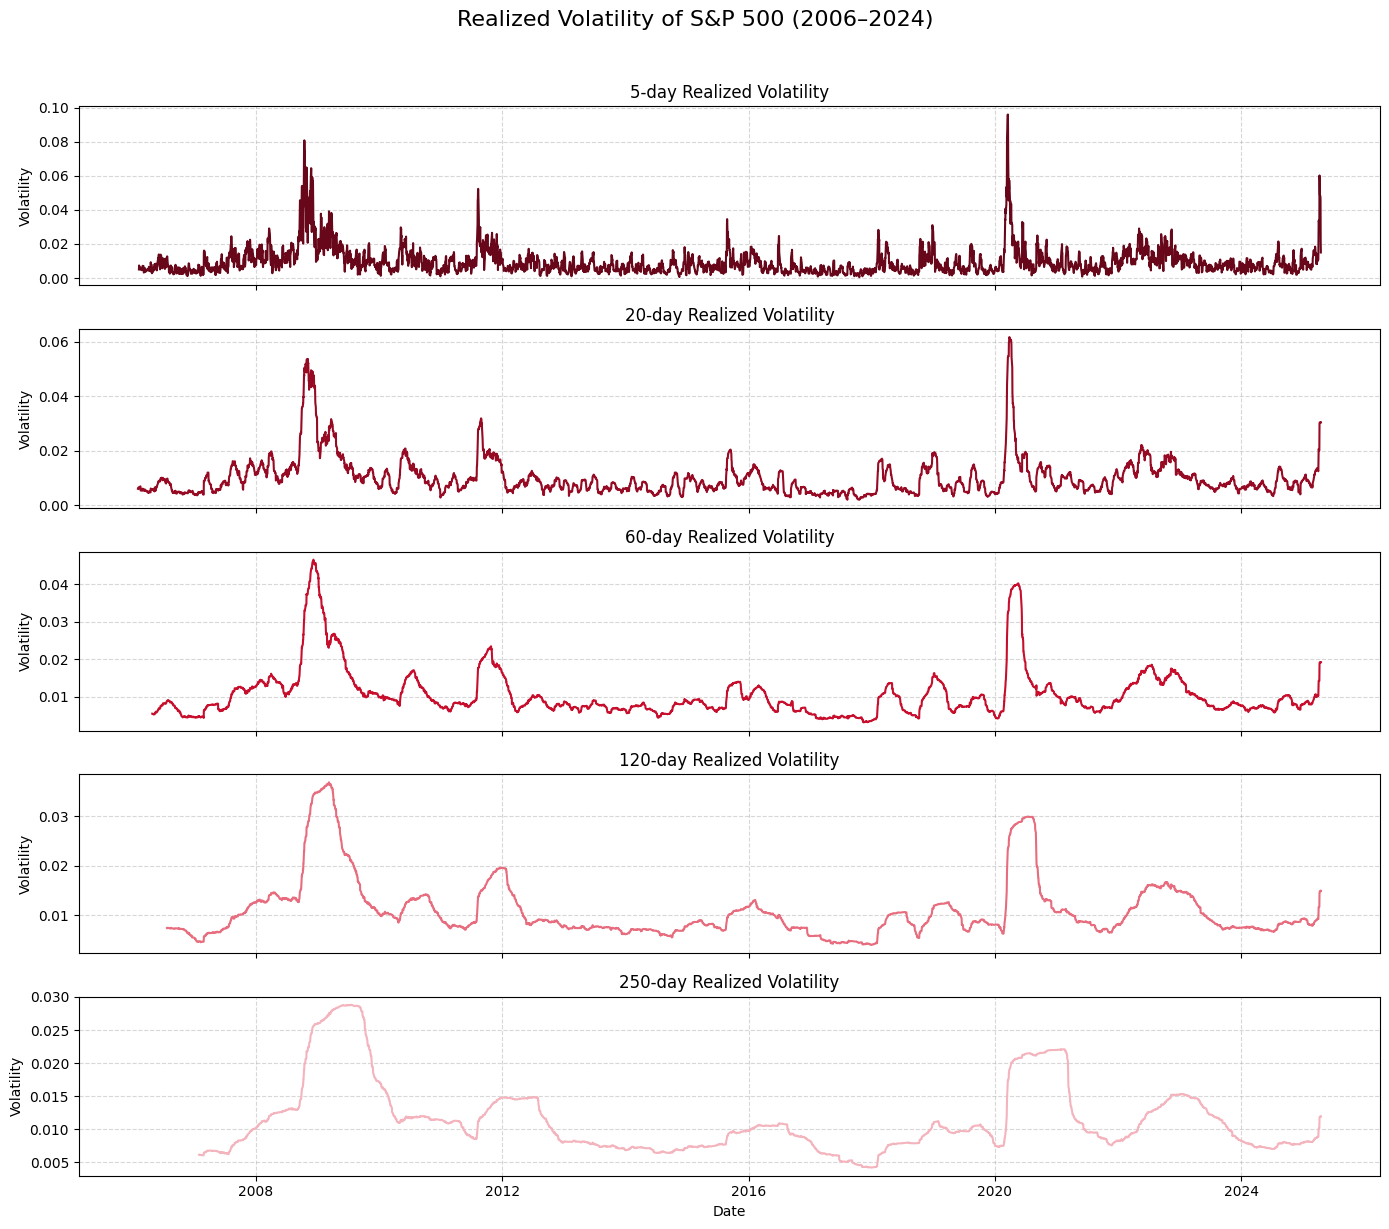

In [5]:
fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

windows = [("realized_volatility_5d", "5-day", '#68071a'),
           ("realized_volatility_20d", "20-day", '#970a24'),
           ("realized_volatility_60d", "60-day", '#c70e2d'),
           ("realized_volatility_120d", "120-day", '#e76d7e'),
           ("realized_volatility_250d", "250-day", '#f4b4bd')]

for ax, (col, label, color) in zip(axes, windows):
    ax.plot(sp500_data.index, sp500_data[col], color=color)
    ax.set_ylabel("Volatility")
    ax.set_title(f"{label} Realized Volatility")
    ax.grid(True, linestyle='--', alpha=0.5)

axes[-1].set_xlabel("Date")
plt.suptitle("Realized Volatility of S&P 500 (2006–2024)", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(r"results/Realized_Volatility_SP500_2006_2024.png", dpi=300, bbox_inches='tight')
plt.show()

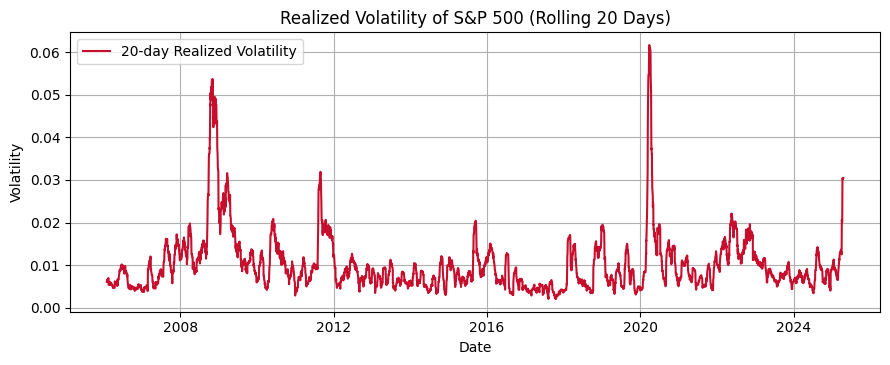

In [6]:
plt.figure(figsize=(9, 3.75))
plt.plot(sp500_data.index, sp500_data["realized_volatility_20d"], label="20-day Realized Volatility", color='#c70e2d')
plt.title("Realized Volatility of S&P 500 (Rolling 20 Days)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Realized_Volatility_SP500_2006_2024_20d.png", dpi=300, bbox_inches='tight')
plt.show()

This histogram displays the empirical distribution of daily log returns with a KDE overlay. The red curve shows the fitted normal distribution with the same mean and standard deviation, allowing for visual comparison. Deviations from the Gaussian shape—such as excess kurtosis or asymmetry—are clearly visible.

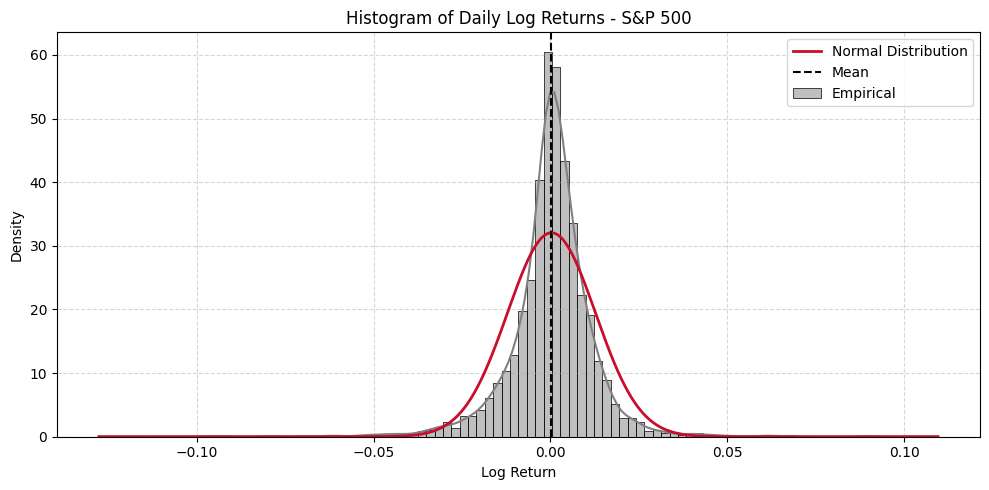

In [7]:
returns = sp500_data['Log_return'].dropna()
mu, sigma = returns.mean(), returns.std()

x = np.linspace(returns.min(), returns.max(), 1000)
pdf_normal = norm.pdf(x, mu, sigma)

# Histogram with KDE + theoretical normal curve
plt.figure(figsize=(10, 5))
sns.histplot(returns, bins=100, kde=True, stat='density', color='grey', label='Empirical')

plt.plot(x, pdf_normal, color='#c70e2d', lw=2, label='Normal Distribution')
plt.axvline(mu, color='black', linestyle='--', label='Mean')

# Labels and style
plt.title("Histogram of Daily Log Returns - S&P 500")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(r"results/Histogram_Daily_Log_Returns_SP500.png", dpi=300, bbox_inches='tight')
plt.show()


## Model Implementations and Results

### VaR simulation using historical volatility

This block estimates the one-day Value at Risk (VaR) using a Monte Carlo simulation under the assumption of constant historical volatility.

Key steps:
- `S0 = 100`: The initial asset price is normalized to 100.

- `T = 1 / 252`: The time horizon corresponds to one trading day.

- `n_sim = 30,000`: Number of simulated price paths.

- `mu, sigma`: Mean and standard deviation of daily log returns, estimated from the data and assumed constant across simulations.

- `Z`: Random shocks drawn from a standard normal distribution.

- `S_hist`: Simulated asset prices using the Black-Scholes formula for geometric Brownian motion.

- `returns_hist`: Corresponding simulated daily returns.

- `VaR_95_hist` and `VaR_99_hist`: Value at Risk at 95% and 99% confidence levels, respectively. These are computed as the empirical 5th and 1st percentiles of the simulated return distribution and then scaled by the initial price.

> ⚠️ This method assumes lognormally distributed returns and constant volatility. While intuitive and simple to implement, it tends to underestimate tail risk, especially during periods of market stress. This motivates the use of more flexible models such as jumps, rough volatility, and stochastic volatility.

In [8]:
# Parameters for simulation
S0 = 100  
T = 1 / 252  
n_sim = 30000
np.random.seed(42)

returns = sp500_data["Log_return"].dropna()
sigma = returns.std()
mu = returns.mean()

# Standard price simulation
Z = np.random.normal(0, 1, n_sim)
S_hist = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
returns_hist = (S_hist - S0) / S0

# VaR computation
VaR_95_hist = -np.percentile(returns_hist, 5) * S0
VaR_99_hist = -np.percentile(returns_hist, 1) * S0

This plot displays the simulated one-day returns obtained from a Monte Carlo simulation using constant historical volatility.

- `returns_hist` contains the returns simulated under a lognormal model,

- The x-axis corresponds to the simulation index (from 1 to 30,000),

- The y-axis shows the return value for each simulated scenario,

- The plot illustrates the range and dispersion of potential daily returns under this volatility assumption.

> This visualization helps build intuition about the simulated distribution of returns before computing the Value at Risk. The shape and spread of the cloud suggest how extreme losses or gains might occur in the absence of jumps or stochastic volatility.

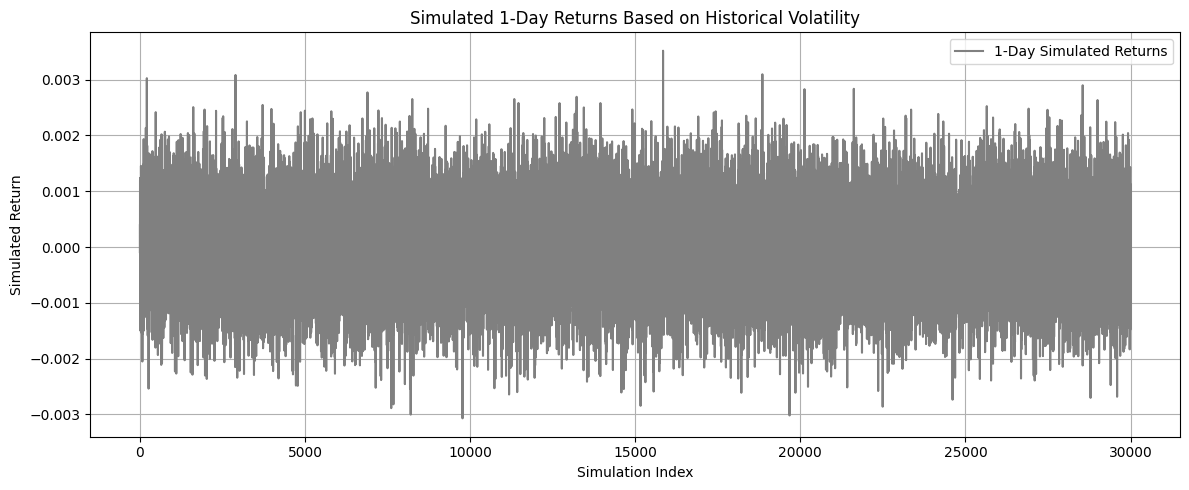

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(returns_hist, label="1-Day Simulated Returns", color='gray')
plt.title("Simulated 1-Day Returns Based on Historical Volatility")
plt.xlabel("Simulation Index")
plt.ylabel("Simulated Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Simulated_1-Day_Returns_Based_on_Historical_Volatility.png", dpi=300, bbox_inches='tight')
plt.show()

This block prints a concise summary of the key parameters and results from the historical volatility-based simulation.

- `σ` (sigma): Estimated daily volatility (standard deviation of log returns).

- `μ` (mu): Estimated daily drift (mean of log returns).

- `VaR 95%`: Value at Risk at the 95% confidence level — i.e., the maximum expected loss in a day with 95% confidence.

- `VaR 99%`: Same as above, but with 99% confidence.

> These results serve as a benchmark for comparing how more sophisticated volatility models (e.g., jump diffusion, rough volatility, SABR) may adjust the tail risk captured by the VaR metric.

In [10]:
# Output
print("Estimated standard parameters:")
print(f"  σ: {sigma:.4f}")
print(f"  μ: {mu:.4f}")

print("\nSimulated 1-day VaR using Historical Volatility:")
print(f"  VaR 95%: {VaR_95_hist:.4f}")
print(f"  VaR 99%: {VaR_99_hist:.4f}")

Estimated standard parameters:
  σ: 0.0124
  μ: 0.0003

Simulated 1-day VaR using Historical Volatility:
  VaR 95%: 0.1270
  VaR 99%: 0.1834


#### Other plots - Historical Volatility

##### Simulated Price Paths and Distribution (Historical Volatility)

This plot combines:

- Left panel: 30,000 simulated price trajectories over a single day, starting from $S_0 = 100$.

- Right panel: The distribution of final prices, showing the empirical density (via KDE), histogram, and a fitted normal distribution.

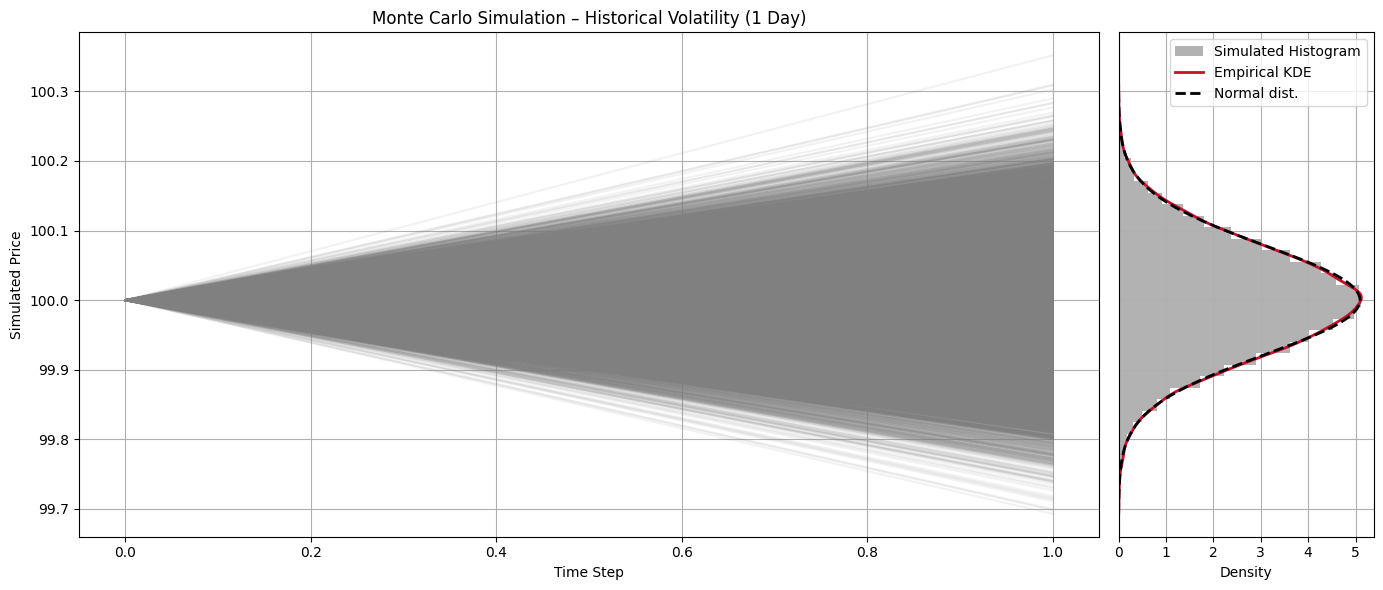

In [11]:
n_paths = 30000
S_paths = S_hist[:n_paths]

# Construct path matrix: start at S0=100, end at S_paths[i]
all_paths = np.vstack([np.full(n_paths, S0), S_paths])  # shape: (2, n_paths)

# Density estimation
kde = gaussian_kde(S_paths)
y_vals = np.linspace(min(S_paths), max(S_paths), 200)
kde_vals = kde(y_vals)

# Normal distribution with same mean and std dev
mu_emp = np.mean(S_paths)
sigma_emp = np.std(S_paths)
norm_vals = norm.pdf(y_vals, loc=mu_emp, scale=sigma_emp)

# --- Combined Plot ---
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

# Left panel: price trajectories
ax0 = plt.subplot(gs[0])
for i in range(n_paths):
    ax0.plot([0, 1], all_paths[:, i], alpha=0.1, color='gray')
ax0.set_title("Monte Carlo Simulation – Historical Volatility (1 Day)")
ax0.set_xlabel("Time Step")
ax0.set_ylabel("Simulated Price")
ax0.grid(True)

# Right panel: distribution
ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.hist(S_paths, bins=40, orientation='horizontal', color='gray', alpha=0.6, density=True, label="Simulated Histogram")
ax1.plot(kde_vals, y_vals, color='#c70e2d', lw=2, label="Empirical KDE")
ax1.plot(norm_vals, y_vals, color='black', linestyle='--', lw=2, label="Normal dist.")
ax1.set_xlabel("Density")
ax1.set_xlim(left=0)
ax1.grid(True)
ax1.tick_params(left=False, labelleft=False)
ax1.legend()

plt.tight_layout()
plt.savefig(r"results/Monte_Carlo_Simulation_Historical_Volatility_(1 Day).png", dpi=300, bbox_inches='tight')
plt.show()

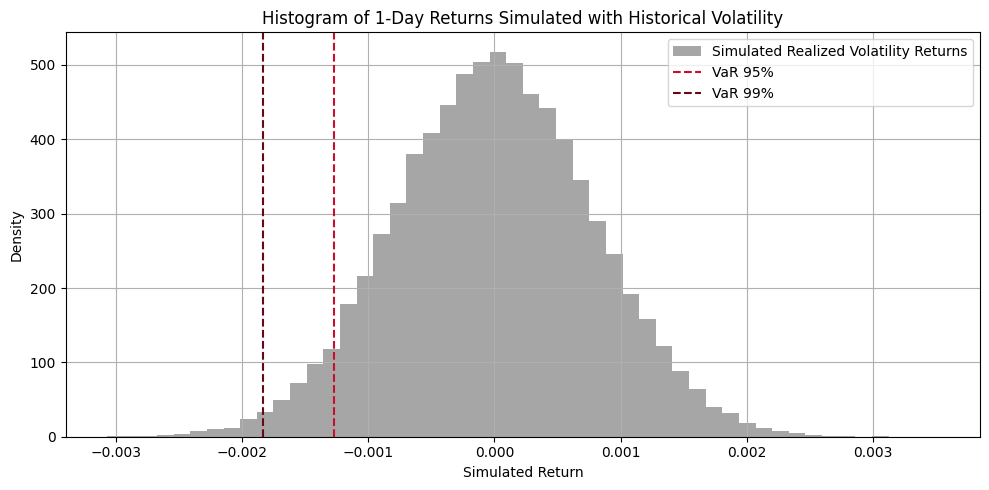

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(returns_hist, bins=50, density=True, alpha=0.7, color='gray', label='Simulated Realized Volatility Returns')
plt.axvline(-VaR_95_hist / S0, color='#c70e2d', linestyle='--', label='VaR 95%')
plt.axvline(-VaR_99_hist / S0, color='#68071a', linestyle='--', label='VaR 99%')
plt.title("Histogram of 1-Day Returns Simulated with Historical Volatility")
plt.xlabel("Simulated Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Histogram_of_1-Day_Returns_Simulated_with_Historical_Volatility.png", dpi=300, bbox_inches='tight')
plt.show()

## Jump-Diffusion Models

### VaR simulation using Merton Jump-Diffusion model

This block simulates asset prices and computes Value at Risk (VaR) under the Merton jump diffusion model, which extends the Black-Scholes framework by adding normally distributed jumps to the log-return process.

The key difference from the historical volatility model is the addition of a jump component, calibrated from empirical return data.

- `N_jumps`: Number of jumps per path, sampled from a Poisson distribution with intensity λ.

- `J`: Total jump impact, modeled as a normally distributed shock scaled by the number of jumps.

- `S_jump`: Simulated price including both continuous Brownian motion and discrete jumps, embedded directly in the exponential term.

- `returns_jump`: Simulated one-day returns under jump dynamics.

- `VaR_95_Merton` and `VaR_99_Merton`: Risk estimates at 95% and 99% confidence, now reflecting higher tail risk due to the possibility of sudden, large price moves.

> Compared to the constant volatility model, Merton’s specification results in fatter tails and typically higher VaR, especially under high confidence levels.

In [13]:
# Estimate jump parameters empirically
# Set a threshold for jump detection
threshold = 2.5 * sigma

# Identify jumps as extreme return events
jumps = returns[np.abs(returns) > threshold]

# Estimate parameters
lambda_jump = len(jumps) / len(returns)         
mu_J = jumps.mean()                             
sigma_J = jumps.std()                                     

# Simulate jump component
np.random.seed(42)
N_jumps = np.random.poisson(lambda_jump * T, n_sim)
J = np.random.normal(mu_J, sigma_J, n_sim) * N_jumps

# Simulate diffusion component
Z = np.random.normal(0, 1, n_sim)
S_jump = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z + J)

# Compute returns and Value at Risk 
returns_jump = (S_jump - S0) / S0
VaR_95_Merton = -np.percentile(returns_jump, 5) * S0
VaR_99_Merton = -np.percentile(returns_jump, 1) * S0

This plot shows the 1-day returns simulated under the Merton jump diffusion model, which adds occasional jumps to the standard Brownian motion dynamics.

> Although jumps increase tail risk, the resulting return distribution does not appear visibly more dispersed than in the constant volatility case. At a daily frequency, the visual impact of jumps may be limited—even if their effect on VaR remains significant.

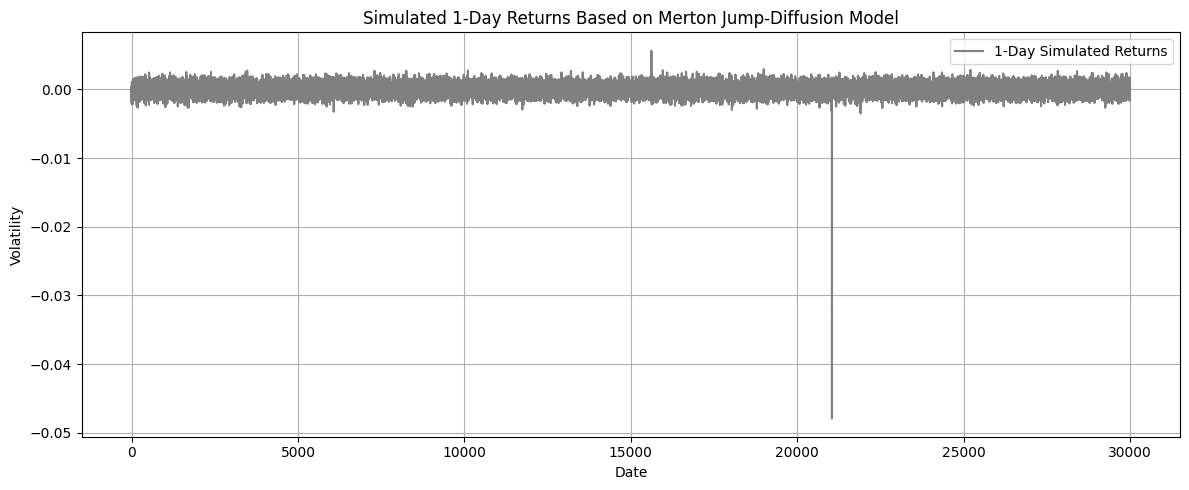

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(returns_jump, label="1-Day Simulated Returns", color='gray')
plt.title("Simulated 1-Day Returns Based on Merton Jump-Diffusion Model")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Simulated_1-Day_Returns_Based_on_Merton_Jump-Diffusion_Model.png", dpi=300, bbox_inches='tight')
plt.show()

This output summarizes the key empirical estimates and simulated risk metrics under the Merton jump diffusion model:

- `λ (lambda)`: Estimated daily frequency of jumps (jump intensity).

- `μ_J` and `σ_J`: Average size and standard deviation of jumps, based on observed extreme returns.

- `Total jumps detected`: Number of jump events relative to the total data sample.

- `VaR 95% / 99%`: One-day Value at Risk, now accounting for jump risk.

Compared to the constant-volatility case, these VaR figures do not show a significant difference, suggesting that tail risk remains broadly similar under both assumptions — even if one might expect greater sensitivity to jumps.

In [15]:
# Output
print("Estimated Merton parameters:")
print(f"  λ (jumps/day): {lambda_jump:.4f}")
print(f"  μ_J (avg. jump size): {mu_J:.4f}")
print(f"  σ_J (jump std dev): {sigma_J:.4f}")
print(f"  Total jumps detected: {len(jumps)} / {len(returns)} days")

print("\nSimulated 1-day Merton Jump Diffusion VaR:")
print(f"  VaR 95%: {VaR_95_Merton:.4f}")
print(f"  VaR 99%: {VaR_99_Merton:.4f}")

Estimated Merton parameters:
  λ (jumps/day): 0.0269
  μ_J (avg. jump size): -0.0090
  σ_J (jump std dev): 0.0505
  Total jumps detected: 130 / 4834 days

Simulated 1-day Merton Jump Diffusion VaR:
  VaR 95%: 0.1291
  VaR 99%: 0.1810


#### Other plots - Merton

##### Jump detection in Historical Returns

This chart highlights the detected jumps in the historical log returns of the S&P 500. Jumps are defined as returns that exceed ±2.5 standard deviations. Red dots represent those extreme values, while dashed lines indicate the threshold boundaries.

> This provides a visual justification for the jump calibration in Jump-Diffusion models.

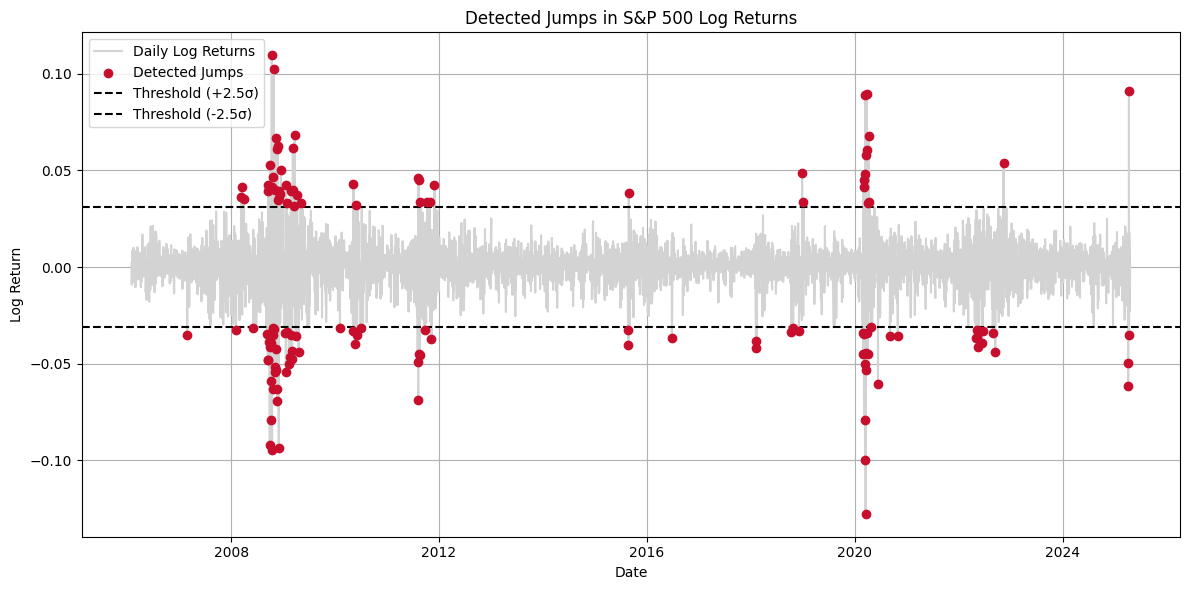

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns, label='Daily Log Returns', color='lightgray')
plt.scatter(jumps.index, jumps, color='#c70e2d', label='Detected Jumps', zorder=5)
plt.axhline(threshold, color='black', linestyle='--', label='Threshold (+2.5σ)')
plt.axhline(-threshold, color='black', linestyle='--', label='Threshold (-2.5σ)')
plt.title("Detected Jumps in S&P 500 Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Detected_Jumps_in_SP500_Log_Returns.png", dpi=300, bbox_inches='tight')
plt.show()

##### Histogram of Simulated Returns with VaR Cutoffs

This histogram shows the distribution of 1-day returns simulated under the Merton jump diffusion model. The vertical dashed lines mark the 95% and 99% Value at Risk levels.

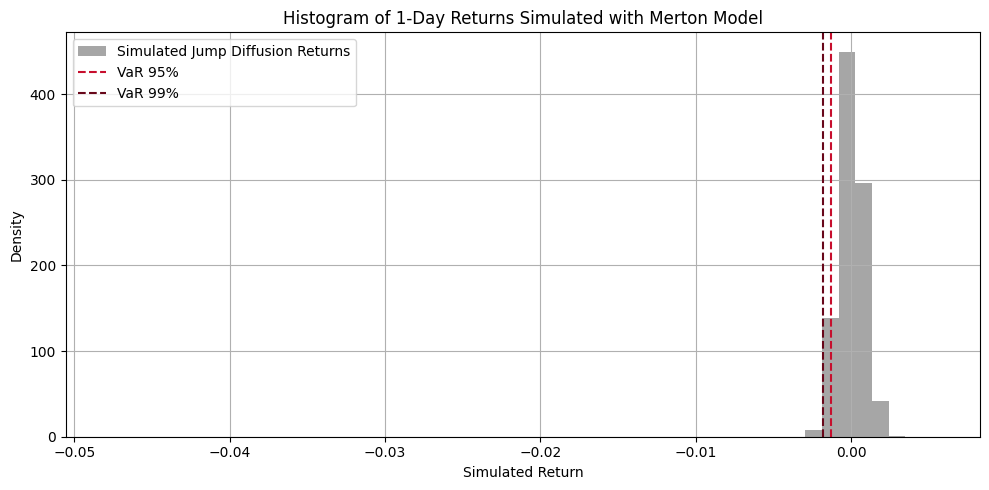

In [17]:

plt.figure(figsize=(10, 5))
plt.hist(returns_jump, bins=50, density=True, alpha=0.7, color='gray', label='Simulated Jump Diffusion Returns')
plt.axvline(-VaR_95_Merton / S0, color='#c70e2d', linestyle='--', label='VaR 95%')
plt.axvline(-VaR_99_Merton / S0, color='#68071a', linestyle='--', label='VaR 99%')
plt.title("Histogram of 1-Day Returns Simulated with Merton Model")
plt.xlabel("Simulated Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Histogram_of_1-Day_Returns_Simulated_with_Merton_Model.png", dpi=300, bbox_inches='tight')
plt.show()

##### Simulated Price Paths and Distribution (Merton)

This plot combines:

- Left panel: 30,000 simulated price trajectories over a single day, starting from $S_0 = 100$, incorporating both continuous and jump components.

- Right panel: The distribution of final prices, showing the empirical density (via KDE), histogram, and a fitted normal distribution.

> Although the jump component is embedded, the overall shape of the distribution remains similar to the Gaussian, with only subtle differences.

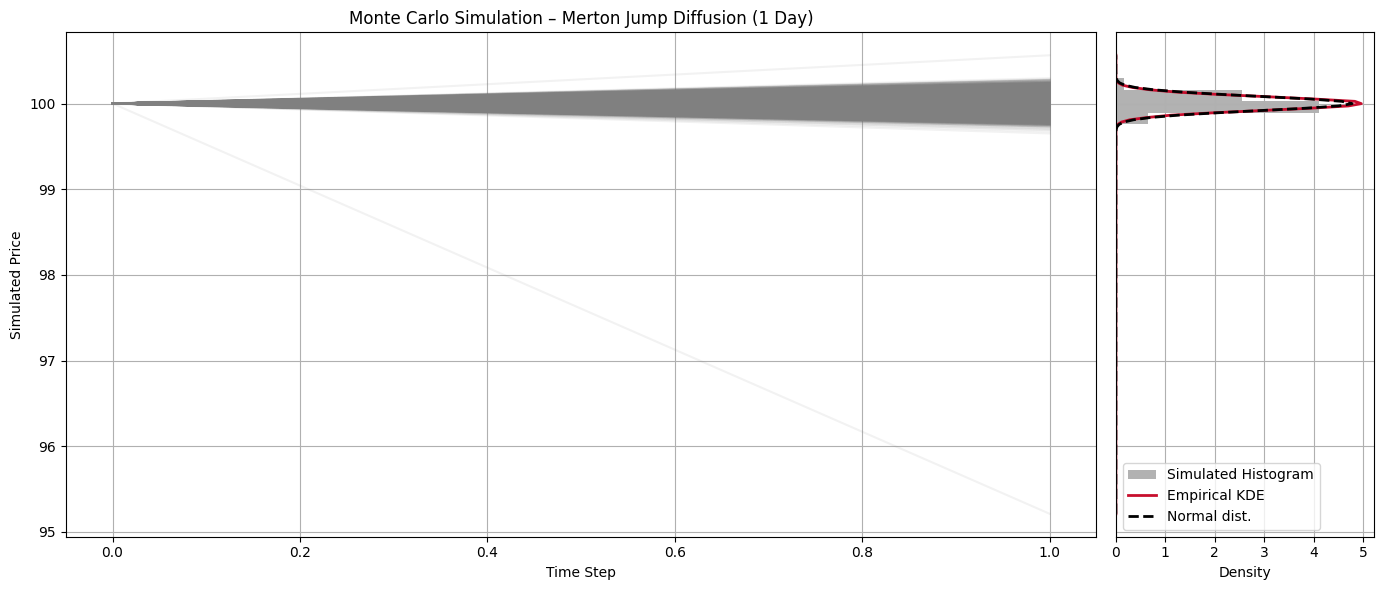

In [18]:
n_paths = 30000
S_paths = S_jump[:n_paths]

# Build paths: from S0 to S_paths[i]
all_paths = np.vstack([np.full(n_paths, S0), S_paths])  # shape: (2, n_paths)

# Density estimation
kde = gaussian_kde(S_paths)
y_vals = np.linspace(min(S_paths), max(S_paths), 200)
kde_vals = kde(y_vals)

# Normal distribution with same empirical mean and std
mu_emp = np.mean(S_paths)
sigma_emp = np.std(S_paths)
norm_vals = norm.pdf(y_vals, loc=mu_emp, scale=sigma_emp)

# --- Combined plot ---
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

# Left panel: trajectories
ax0 = plt.subplot(gs[0])
for i in range(n_paths):
    ax0.plot([0, 1], all_paths[:, i], alpha=0.1, color='gray')
ax0.set_title("Monte Carlo Simulation – Merton Jump Diffusion (1 Day)")
ax0.set_xlabel("Time Step")
ax0.set_ylabel("Simulated Price")
ax0.grid(True)

# Right panel: distribution
ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.hist(S_paths, bins=40, orientation='horizontal', color='gray', alpha=0.6, density=True, label="Simulated Histogram")
ax1.plot(kde_vals, y_vals, color='#c70e2d', lw=2, label='Empirical KDE')
ax1.plot(norm_vals, y_vals, color='black', linestyle='--', lw=2, label='Normal dist.')
ax1.set_xlabel("Density")
ax1.set_xlim(left=0)
ax1.grid(True)
ax1.tick_params(left=False, labelleft=False)
ax1.legend()

plt.tight_layout()
plt.savefig(r"results/Monte_Carlo_Simulation_Merton_Jump_Diffusion_(1 Day).png", dpi=300, bbox_inches='tight')
plt.show()

### VaR simulation using Kou Jump-Diffusion model

This block simulates 1-day returns under the Kou jump diffusion model, an extension of Merton’s that allows for asymmetric jump behavior by using a double-exponential distribution for jump sizes.

Key differences vs. Merton:
- Jumps are not normally distributed, but instead follow a double exponential distribution, with different decay rates for upward and downward jumps.

- The model separates positive and negative jumps and calibrates:

    - `p_kou`: Probability of an upward jump.

    - `eta1_kou`, `eta2_kou`: Rate parameters for positive and negative jumps, respectively.

In [19]:
# Separate positive and negative jumps
jumps_pos = jumps[jumps > 0]
jumps_neg = jumps[jumps < 0]

# Estimate Kou parameters from jump data
p_kou = len(jumps_pos) / len(jumps)                         
eta1_kou = 1 / jumps_pos.mean() if len(jumps_pos) > 0 else np.nan  
eta2_kou = 1 / abs(jumps_neg.mean()) if len(jumps_neg) > 0 else np.nan 

lambda_kou = lambda_jump  # Use same jump frequency estimated earlier

Jump Simulation Logic:
- For each simulation, the number of jumps is drawn from a Poisson distribution.

- Each jump is randomly assigned as upward or downward.

- Sizes are sampled from exponential distributions with parameters `η₁` and `η₂`.

In [20]:
# Simulate jump component: double exponential
def simulate_kou_jumps(n, lmbda, dt, p_kou, eta1_kou, eta2_kou):
    N = np.random.poisson(lmbda * dt, n)
    J = np.zeros(n)
    for i in range(n):
        for _ in range(N[i]):
            if np.random.rand() < p_kou:
                J[i] += np.random.exponential(1 / eta1_kou)  # positive jump
            else:
                J[i] -= np.random.exponential(1 / eta2_kou)  # negative jump
    return J

# Simulate
J_kou = simulate_kou_jumps(n_sim, lambda_kou, T, p_kou, eta1_kou, eta2_kou)

Full price Simulation and Risk Measures:
- Price paths are simulated as in the Merton model, but with asymmetric jumps.

- VaR at 95% and 99% is computed from the resulting return distribution.

> The Kou model captures skewed risk more realistically, which may impact VaR asymmetry and the tail structure—especially under stress.

In [21]:
# Simulate full price paths
Z = np.random.normal(0, 1, n_sim)
S_kou = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z + J_kou)

# Compute returns and VaR
returns_kou = (S_kou - S0) / S0
VaR_95_kou = -np.percentile(returns_kou, 5) * S0
VaR_99_kou = -np.percentile(returns_kou, 1) * S0

This plot displays the 1-day returns simulated under the Kou jump diffusion model, which allows for asymmetric jumps based on a double-exponential distribution.

Unlike the Merton model, here the presence of jumps is more visually evident:

- The return distribution includes more pronounced spikes and outliers, reflecting the model’s ability to capture sudden upward or downward movements in price.

- This increased dispersion confirms the heavier tails and asymmetry induced by the Kou specification.

> In this case, jump risk is not only captured statistically but also becomes visually noticeable, reinforcing its relevance for VaR estimation.

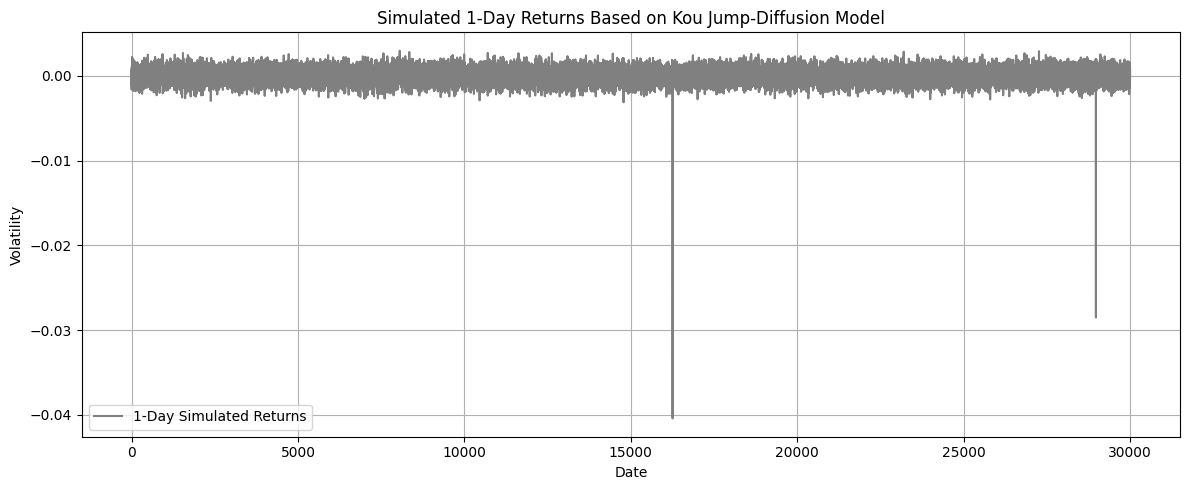

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(returns_kou, label="1-Day Simulated Returns", color='gray')
plt.title("Simulated 1-Day Returns Based on Kou Jump-Diffusion Model")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Simulated_1-Day_Returns_Based_on_Kou_Jump-Diffusion_Model.png", dpi=300, bbox_inches='tight')
plt.show()

This output summarizes the key estimated parameters and resulting risk measures under Kou’s jump diffusion model:

- `p`: Empirical probability of upward jumps.

- `η₁`, `η₂`: Inverse of the average size of positive and negative jumps, respectively (higher η implies smaller, more frequent jumps).

- `VaR 95% / 99%`: Value at Risk estimates accounting for asymmetric and fat-tailed jump behavior.

> Compared to Merton, Kou’s model often results in greater downside risk due to the steeper decay of large negative jumps, and thus may produce slightly higher VaR at extreme percentiles. However, the differences are not substantial, suggesting that both models yield broadly comparable risk estimates in practice.



In [23]:
# Output
print("Estimated Kou parameters:")
print(f"  p (prob. positive jump): {p_kou:.4f}")
print(f"  η₁ (positive intensity): {eta1_kou:.2f}")
print(f"  η₂ (negative intensity): {eta2_kou:.2f}")

print("\nSimulated 1-day Kou Jump Diffusion VaR:")
print(f"  VaR 95%: {VaR_95_kou:.4f}")
print(f"  VaR 99%: {VaR_99_kou:.4f}")

Estimated Kou parameters:
  p (prob. positive jump): 0.3923
  η₁ (positive intensity): 20.35
  η₂ (negative intensity): 21.46

Simulated 1-day Kou Jump Diffusion VaR:
  VaR 95%: 0.1286
  VaR 99%: 0.1839


#### Other plots - Kou

##### Simulated Price Paths and Distribution (Kou)

This plot combines:

Left panel: 30,000 simulated price trajectories over a single day, starting from $S_0=100$, under Kou’s jump diffusion model. Each path includes both a continuous Brownian component and asymmetric jumps drawn from a double-exponential distribution.

- Right panel: The distribution of final simulated prices:

    - Gray histogram: empirical distribution of prices at time $T$,

    - Red line: Kernel Density Estimate (KDE) representing the smoothed empirical density,

    - Dashed black line: a normal distribution fitted to the simulated mean and standard deviation.

> Thanks to Kou’s flexible jump specification, the price distribution exhibits visible asymmetry and fat tails, deviating more clearly from the Gaussian shape. These characteristics directly influence tail-risk metrics such as VaR.



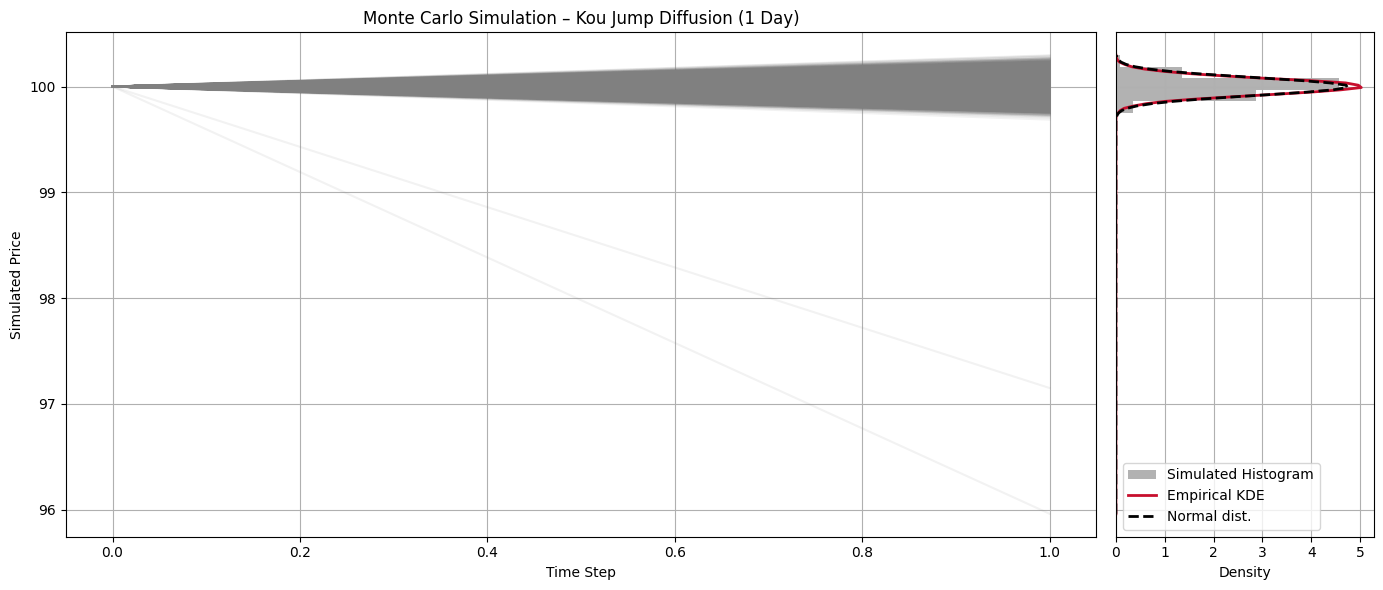

In [24]:
n_paths = 30000
S_paths = S_kou[:n_paths]  

# Construct paths [S0, S1]
all_paths = np.vstack([np.full(n_paths, S0), S_paths])  # shape: (2, n_paths)

# Density estimation
kde = gaussian_kde(S_paths)
y_vals = np.linspace(min(S_paths), max(S_paths), 200)
kde_vals = kde(y_vals)

# Empirical normal distribution
mu_emp = np.mean(S_paths)
sigma_emp = np.std(S_paths)
norm_vals = norm.pdf(y_vals, loc=mu_emp, scale=sigma_emp)

# --- Combined plot ---
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

# Trajectories (left)
ax0 = plt.subplot(gs[0])
for i in range(n_paths):
    ax0.plot([0, 1], all_paths[:, i], alpha=0.1, color='gray')
ax0.set_title("Monte Carlo Simulation – Kou Jump Diffusion (1 Day)")
ax0.set_xlabel("Time Step")
ax0.set_ylabel("Simulated Price")
ax0.grid(True)

# Distribution (right)
ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.hist(S_paths, bins=40, orientation='horizontal', color='gray', alpha=0.6, density=True, label="Simulated Histogram")
ax1.plot(kde_vals, y_vals, color='#c70e2d', lw=2, label='Empirical KDE')
ax1.plot(norm_vals, y_vals, color='black', linestyle='--', lw=2, label='Normal dist.')
ax1.set_xlabel("Density")
ax1.set_xlim(left=0)
ax1.grid(True)
ax1.tick_params(left=False, labelleft=False)
ax1.legend()

plt.tight_layout()
plt.savefig(r"results/Monte_Carlo_Simulation_Kou_Jump_Diffusion_(1 Day).png", dpi=300, bbox_inches='tight')
plt.show()

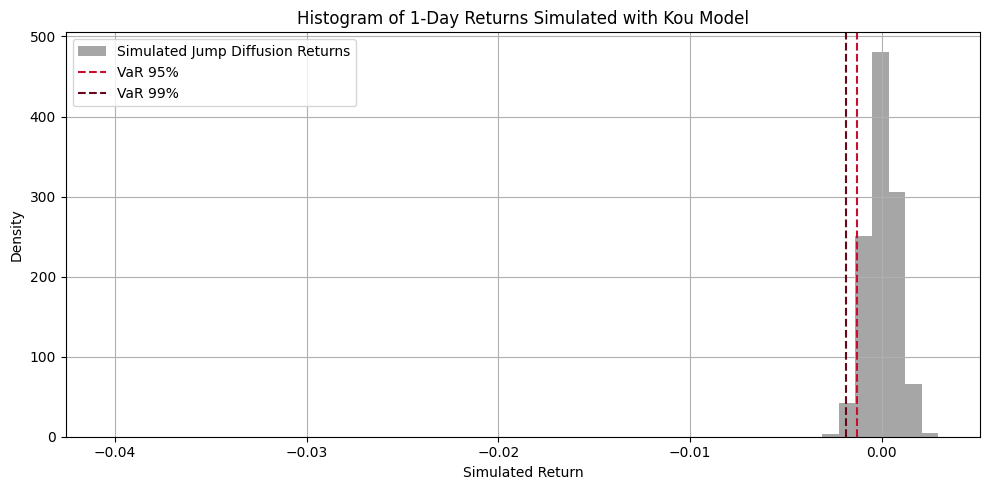

In [25]:
plt.figure(figsize=(10, 5))
plt.hist(returns_kou, bins=50, density=True, alpha=0.7, color='gray', label='Simulated Jump Diffusion Returns')
plt.axvline(-VaR_95_kou / S0, color='#c70e2d', linestyle='--', label='VaR 95%')
plt.axvline(-VaR_99_kou / S0, color='#68071a', linestyle='--', label='VaR 99%')
plt.title("Histogram of 1-Day Returns Simulated with Kou Model")
plt.xlabel("Simulated Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Histogram_of_1-Day_Returns_Simulated_with_Kou_Model.png", dpi=300, bbox_inches='tight')
plt.show()

## Rough Volatility Models

### VaR simulation using Rough Volatility model

This block estimates Value at Risk using a rough volatility model, where the log-volatility evolves according to a fractional Brownian motion (fBM) with Hurst exponent $H < 1$. In our calibrations, $H$ typically lies around 0.7–0.8, which reflects the persistent and long-memory nature of volatility observed in empirical data. While models with $H < 0.5$ are often referred to as "rough" due to their anti-persistent, highly irregular behavior at short time scales, our results suggest a smoother but still non-Markovian structure.

- `xi_0`: Initial (mean) volatility level.

- `nu`: Volatility of volatility.

- `H`: Estimated Hurst exponent, typically around 0.1–0.2, indicating rough behavior.

In [26]:
#Calibration
# 1. Mean volatility
xi_0 = sp500_data["realized_volatility_20d"].mean()

# 2. Volatility of the volatility
nu = sp500_data["realized_volatility_20d"].std()

# 4. Hurst exponent estimation
H, _, _ = compute_Hc(sp500_data["realized_volatility_20d"], kind='price')

- Each simulation uses a different realization of fractional Brownian motion to generate path-dependent, non-Markovian volatility $\sigma _t$

- The final price $S_1$ is simulated using Black-Scholes, but with volatility drawn from the rough process.

In [27]:
#Simulation
S_rough = np.zeros(n_sim)
returns_rough = np.zeros(n_sim)

for i in range(n_sim):
    f = FBM(n=1, hurst=H, length=T, method='daviesharte')
    W_H = f.fbm()[1]
    sigma_t = xi_0 * np.exp(nu * W_H - 0.5 * (nu**2) * T**(2 * H))
    Z = np.random.normal(0, 1)
    S1 = S0 * np.exp((mu - 0.5 * sigma_t**2) * T + sigma_t * np.sqrt(T) * Z)
    S_rough[i] = S1
    returns_rough[i] = (S1 - S0) / S0

- VaR is computed from the distribution of simulated returns, as in previous models.

In [28]:
#VaR Computation
VaR_95_rough = -np.percentile(returns_rough, 5) * S0
VaR_99_rough = -np.percentile(returns_rough, 1) * S0

This plot displays the 1-day returns simulated using the rough volatility model, where volatility evolves according to a fractional Brownian motion with low Hurst exponent.

Although rough volatility is known to generate heavy tails and irregular behavior, these characteristics are not clearly visible in the simulated returns at a daily frequency. The plot shows a return cloud that resembles the constant volatility case, with no obvious increase in dispersion.

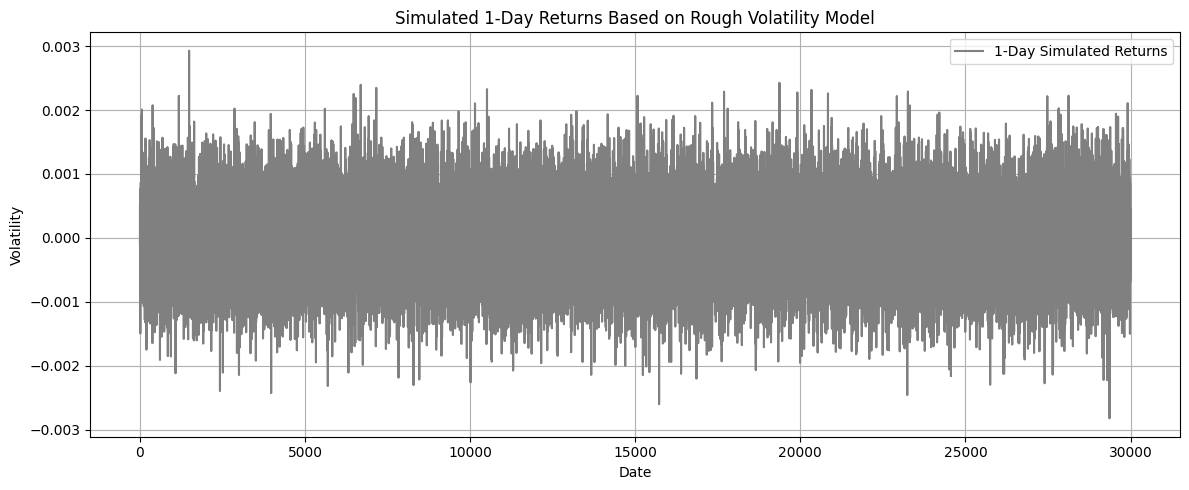

In [29]:
plt.figure(figsize=(12, 5))
plt.plot(returns_rough, label="1-Day Simulated Returns", color='gray')
plt.title("Simulated 1-Day Returns Based on Rough Volatility Model")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Simulated_1-Day_Returns_Based_on_Rough_Volatility_Model.png", dpi=300, bbox_inches='tight')
plt.show()

This output shows the key calibration parameters for the rough volatility model and the resulting risk estimates:

- `μ`: Historical annualized drift.

- `ξ₀`: Average volatility level (used as base for the stochastic process).

- `ν`: Volatility of volatility.

- `H`: Hurst exponent, capturing the degree of roughness (typically $𝐻<0.5$).

The VaR figures reflect the simulated 1-day risk under this model, which embeds pathwise irregularity and short-memory effects.

> Contrary to common expectations, rough volatility in this case produces lower VaR estimates compared to other models. This may be due to the estimated Hurst exponent being greater than 0.5, which implies smoother and more persistent volatility dynamics, reducing the short-term variability that typically drives tail risk in high-frequency data.

In [30]:
print(f"Calibrated parameters:")
print(f"  μ (drift, annualized): {mu:.4f}")
print(f"  ξ₀ (mean volatility): {xi_0:.4f}")
print(f"  ν (vol of vol): {nu:.4f}")
print(f"  H (Hurst exponent): {H:.4f}")

print(f"\nRough Volatility VaR:")
print(f"  VaR 95%: {VaR_95_rough:.4f}")
print(f"  VaR 99%: {VaR_99_rough:.4f}")

Calibrated parameters:
  μ (drift, annualized): 0.0003
  ξ₀ (mean volatility): 0.0102
  ν (vol of vol): 0.0072
  H (Hurst exponent): 0.7041

Rough Volatility VaR:
  VaR 95%: 0.1050
  VaR 99%: 0.1470


#### Other plots - Rough

##### Simulated Price Paths and Distribution (Rough Volatility Model)

This plot combines:

- Left panel: 30,000 simulated 1-day price trajectories under the rough volatility model.
    Volatility in each path is generated via a fractional Brownian motion with low Hurst exponent, introducing pathwise irregularity. However, at such a short time horizon, the effect is not visibly distinguishable from simpler models.

- Right panel: Distribution of final simulated prices:

    - The histogram shows the empirical distribution across 30,000 simulations.

    - The red curve (KDE) reflects the smoothed empirical density.

    - The dashed black line is a normal distribution fitted to the mean and standard deviation of the simulated prices.

> The resulting distribution is visually almost identical to the Gaussian, with no evident skewness or heavy tails. This highlights that, at daily frequency, the impact of rough volatility is subtle and may not manifest strongly in the return distribution.

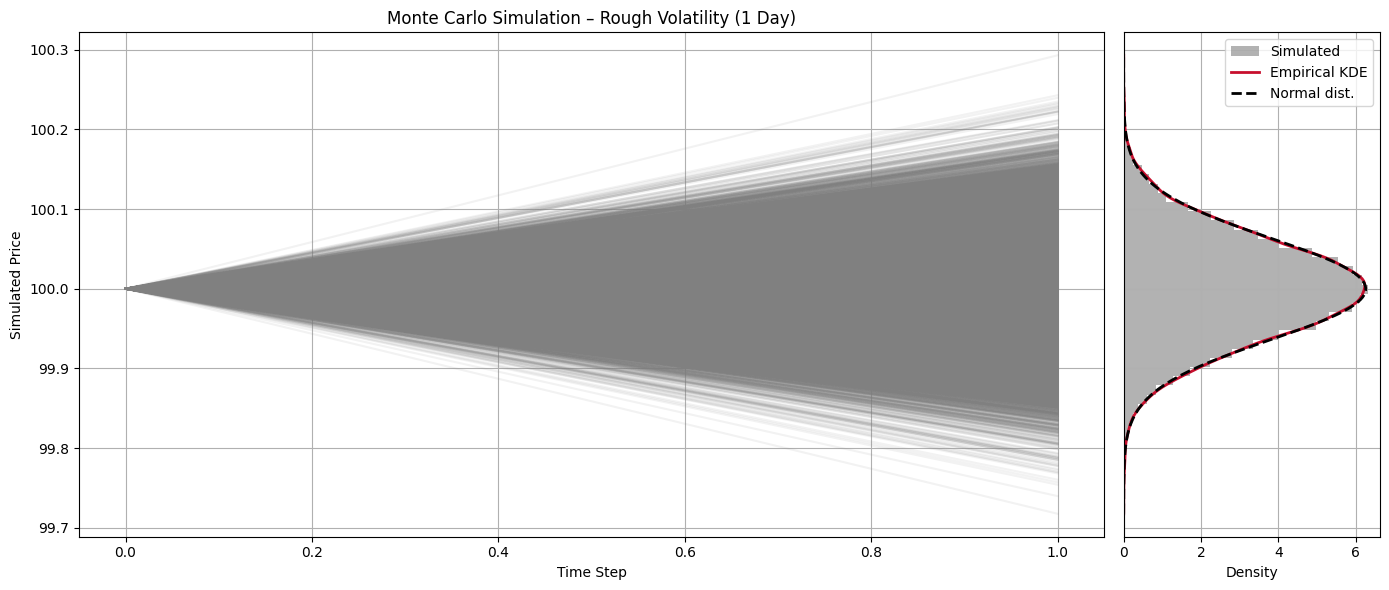

In [31]:
n_paths = 30000
S_paths = S_rough[:n_paths] 

# Construct paths [S0, S1]
simulated_paths = np.vstack([np.full(n_paths, S0), S_paths])  # shape: (2, n_paths)

# Densities
kde = gaussian_kde(S_paths)
y_vals = np.linspace(min(S_paths), max(S_paths), 200)
kde_vals = kde(y_vals)

# Normal distribution for comparison
mu_emp = np.mean(S_paths)
sigma_emp = np.std(S_paths)
norm_vals = norm.pdf(y_vals, loc=mu_emp, scale=sigma_emp)

# --- Combined plot ---
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

# Left: trajectories
ax0 = plt.subplot(gs[0])
for i in range(n_paths):
    ax0.plot([0, 1], simulated_paths[:, i], alpha=0.1, color='gray')
ax0.set_title("Monte Carlo Simulation – Rough Volatility (1 Day)")
ax0.set_xlabel("Time Step")
ax0.set_ylabel("Simulated Price")
ax0.grid(True)

# Right: distribution
ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.hist(S_paths, bins=50, orientation='horizontal', density=True, alpha=0.6, color='gray', label='Simulated')
ax1.plot(kde_vals, y_vals, color='#c70e2d', lw=2, label='Empirical KDE')
ax1.plot(norm_vals, y_vals, color='black', linestyle='--', lw=2, label='Normal dist.')
ax1.set_xlabel("Density")
ax1.set_xlim(left=0)
ax1.grid(True)
ax1.tick_params(left=False, labelleft=False)
ax1.legend()

plt.tight_layout()
plt.savefig(r"results/Monte_Carlo_Simulation_Rough_Volatility_(1 Day).png", dpi=300, bbox_inches='tight')
plt.show()

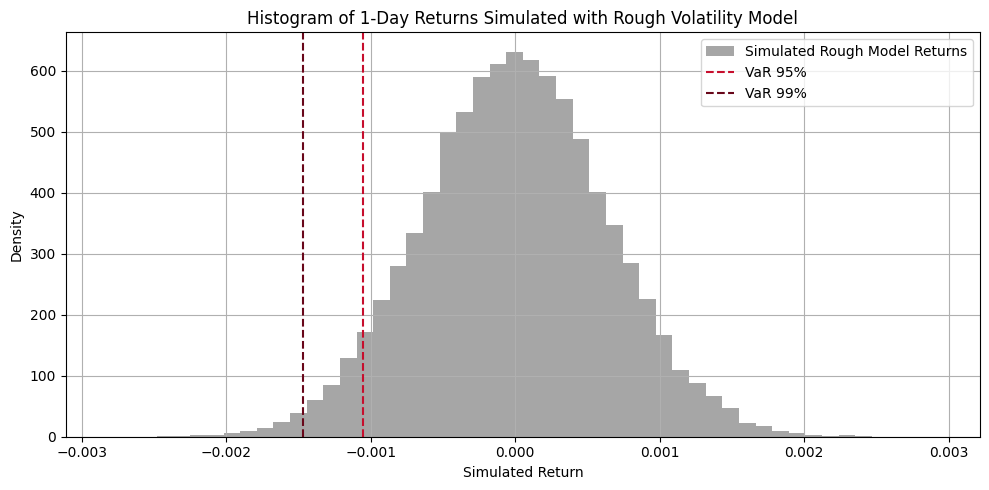

In [32]:
plt.figure(figsize=(10, 5))
plt.hist(returns_rough, bins=50, density=True, alpha=0.7, color='gray', label='Simulated Rough Model Returns')
plt.axvline(-VaR_95_rough / S0, color='#c70e2d', linestyle='--', label='VaR 95%')
plt.axvline(-VaR_99_rough / S0, color='#68071a', linestyle='--', label='VaR 99%')
plt.title("Histogram of 1-Day Returns Simulated with Rough Volatility Model")
plt.xlabel("Simulated Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Histogram_of_1-Day_Returns_Simulated_with_Rough_Volatility_Model.png", dpi=300, bbox_inches='tight')
plt.show()

## SABR Model

### VaR simulation using SABR model

This block simulates 1-day returns using a simplified SABR model adapted to spot prices rather than forward prices, assuming $𝛽=1$ (log-normal case). The SABR framework introduces stochastic volatility and a correlation between volatility and price shocks, often used to model volatility skew.

- The correlation ρ is computed from historical data, capturing the leverage effect.

- The volatility process is modeled as lognormal, with randomness driven by a second Brownian motion $𝑍_2$, correlated with the asset's return shock $𝑍_1$.

In [33]:
# Calibration
xi_0 = sp500_data["realized_volatility_20d"].mean()
nu = sp500_data["realized_volatility_20d"].std()
beta = 1  # log-normal case
log_ret = sp500_data["Log_return"]
delta_vol = sp500_data["realized_volatility_20d"].diff()

aligned = pd.concat([log_ret, delta_vol], axis=1).dropna()  # Align both time series
rho = np.corrcoef(aligned.iloc[:, 0], aligned.iloc[:, 1])[0, 1]

Each simulated return uses:

- A shock to volatility:  
  $
  \sigma_1 = \xi_0 \cdot \exp\left(\nu Z_2 \sqrt{T} - \frac{1}{2} \nu^2 T\right)
  $

- A shock to the price, given the simulated \(\sigma_1\):  
  $
  S_1 = S_0 \cdot \exp\left(-\frac{1}{2} \sigma_1^2 T + \sigma_1 \sqrt{T} Z_1\right)
  $

This allows volatility to vary across paths and be correlated with price changes.

In [34]:
# Simulation
S_sabr = np.zeros(n_sim)
returns_sabr = np.zeros(n_sim)
T = 1 / 252
S0 = 100

for i in range(n_sim):
    Z1 = np.random.normal(0, 1)
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1)

    sigma_1 = xi_0 * np.exp(nu * Z2 * np.sqrt(T) - 0.5 * (nu**2) * T)
    S1 = S0 * np.exp(-0.5 * (sigma_1**2) * T + sigma_1 * np.sqrt(T) * Z1)
    S_sabr[i] = S1
    returns_sabr[i] = (S1 - S0) / S0

- VaR is computed from the simulated return distribution, reflecting the impact of stochastic volatility and correlated shocks.

In [35]:
# VaR
VaR_95_sabr = -np.percentile(returns_sabr, 5) * S0
VaR_99_sabr = -np.percentile(returns_sabr, 1) * S0

This plot shows the simulated 1-day returns under the SABR stochastic volatility model (with log-normal dynamics and correlated shocks).

Despite incorporating stochastic volatility and correlation between price and volatility changes, the resulting distribution of returns appears visually similar to those obtained under simpler models like historical or rough volatility.

> No clear differences in dispersion or tail behavior are evident from the return cloud.

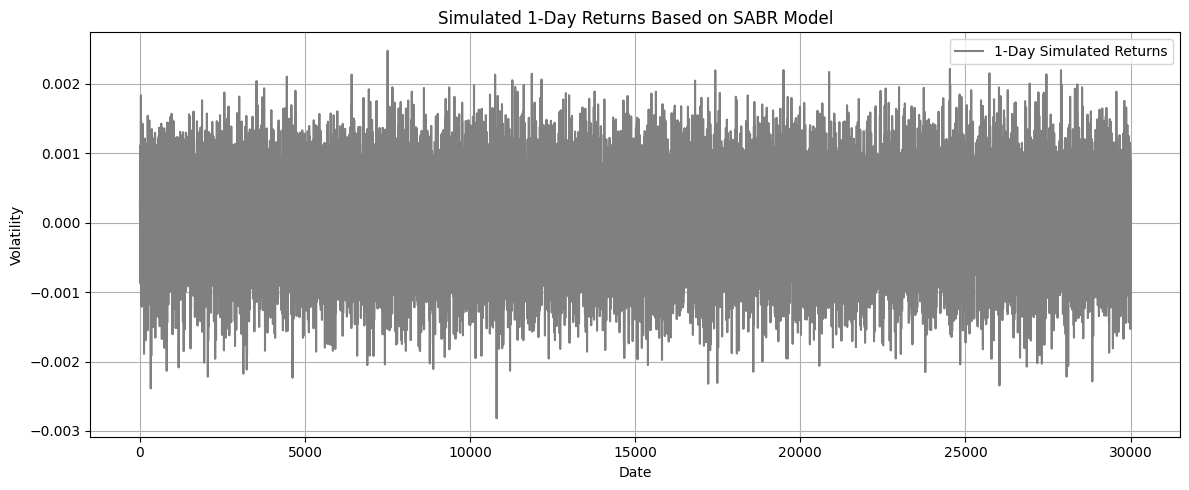

In [36]:
plt.figure(figsize=(12, 5))
plt.plot(returns_sabr, label="1-Day Simulated Returns", color='gray')
plt.title("Simulated 1-Day Returns Based on SABR Model")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Simulated_1-Day_Returns_Based_on_SABR_Model.png", dpi=300, bbox_inches='tight')
plt.show()

This output displays the calibrated parameters for the SABR model and the resulting 1-day Value at Risk:

- `μ`: Annualized drift of returns.

- `ξ₀`: Mean volatility level.

- `ν`: Volatility of volatility.

- `β`: Elasticity parameter, set to 1 for log-normal dynamics.

- `ρ`: Correlation between return and volatility shocks (captures the leverage effect).

> Similarly, the SABR model yields VaR estimates very close to those of the rough volatility model, and noticeably lower than those obtained with jump-diffusion or historical volatility approaches. This suggests that, for the dataset considered, stochastic volatility models may underrepresent tail risk, potentially due to parameter calibrations that smooth out short-term fluctuations.

In [37]:
print(f"Calibrated parameters (SABR):")
print(f"  μ (drift, annualized): {mu:.4f}")
print(f"  ξ₀ (mean volatility): {xi_0:.4f}")
print(f"  ν (vol of vol): {nu:.4f}")
print(f"  β (elasticity parameter): {beta}")
print(f"  ρ (correlation): {rho:.4f}")

print(f"\nSABR Model VaR:")
print(f"  VaR 95%: {VaR_95_sabr:.4f}")
print(f"  VaR 99%: {VaR_99_sabr:.4f}")

Calibrated parameters (SABR):
  μ (drift, annualized): 0.0003
  ξ₀ (mean volatility): 0.0102
  ν (vol of vol): 0.0072
  β (elasticity parameter): 1
  ρ (correlation): -0.0835

SABR Model VaR:
  VaR 95%: 0.1044
  VaR 99%: 0.1495


#### Other Plots - SABR

##### Simulated Price Paths and Distribution (SABR Model)

This plot shows the output of a Monte Carlo simulation using the SABR stochastic volatility model (with 𝛽=1, i.e., log-normal dynamics):

- Left panel: 30,000 simulated price trajectories over a one-day horizon.
    Each path incorporates stochastic volatility and correlated shocks between the asset price and volatility processes. However, over such a short time frame, the trajectories appear visually similar to those generated by simpler models.

- Right panel: Histogram of final prices across all simulations:

    - The empirical KDE (red line) closely follows the fitted normal distribution (dashed black line),

    - No clear skewness or fat tails are observed in the distribution.

> Despite the model’s complexity, the resulting price distribution is nearly Gaussian, suggesting that the stochastic volatility and correlation embedded in SABR may have limited impact at the 1-day horizon.

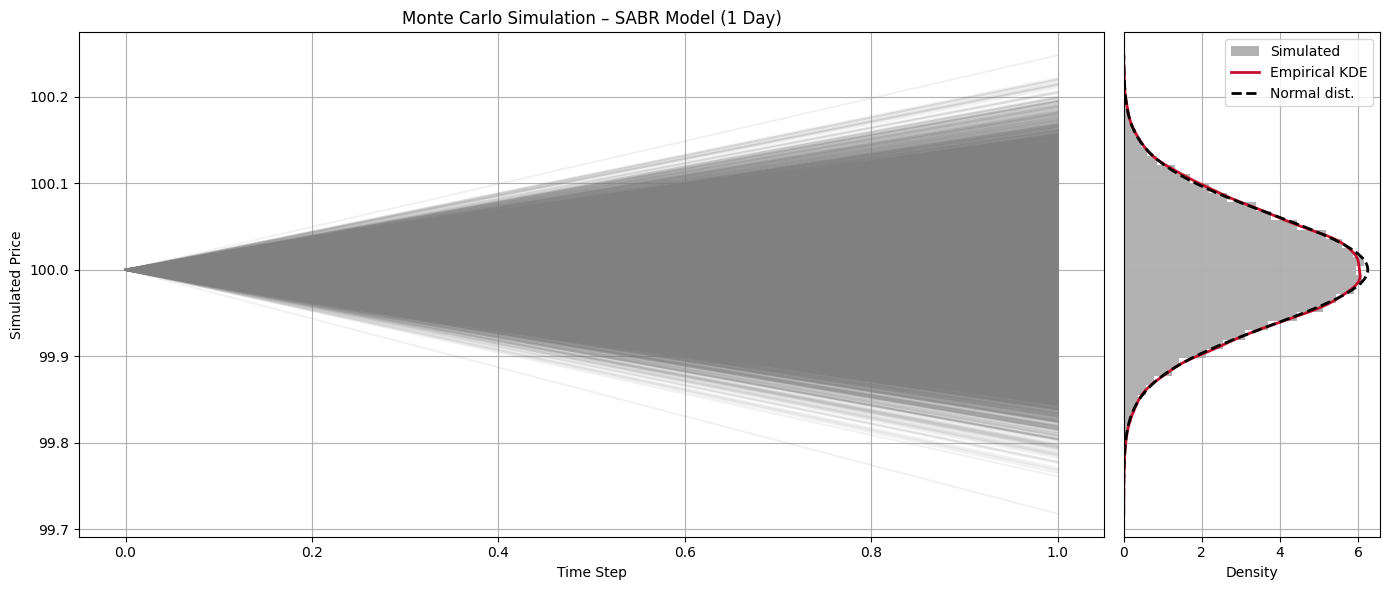

In [38]:
n_paths = 30000
S_paths = S_sabr[:n_paths]  

# Construct paths [S0, S1]
simulated_paths = np.vstack([np.full(n_paths, S0), S_paths])  # shape: (2, n_paths)

# Density estimation
kde = gaussian_kde(S_paths)
y_vals = np.linspace(min(S_paths), max(S_paths), 200)
kde_vals = kde(y_vals)

# Normal distribution
mu_emp = np.mean(S_paths)
sigma_emp = np.std(S_paths)
norm_vals = norm.pdf(y_vals, loc=mu_emp, scale=sigma_emp)

# --- Combined Plot ---
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

# Left panel: trajectories
ax0 = plt.subplot(gs[0])
for i in range(n_paths):
    ax0.plot([0, 1], simulated_paths[:, i], alpha=0.1, color='gray')
ax0.set_title("Monte Carlo Simulation – SABR Model (1 Day)")
ax0.set_xlabel("Time Step")
ax0.set_ylabel("Simulated Price")
ax0.grid(True)

# Right panel: distribution
ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.hist(S_paths, bins=50, orientation='horizontal', density=True, alpha=0.6, color='gray', label='Simulated')
ax1.plot(kde_vals, y_vals, color='#c70e2d', lw=2, label='Empirical KDE')
ax1.plot(norm_vals, y_vals, color='black', linestyle='--', lw=2, label='Normal dist.')
ax1.set_xlabel("Density")
ax1.set_xlim(left=0)
ax1.grid(True)
ax1.tick_params(left=False, labelleft=False)
ax1.legend()

plt.tight_layout()
plt.savefig(r"results/Monte_Carlo_Simulation_SABR_Model_(1 Day).png", dpi=300, bbox_inches='tight')
plt.show()

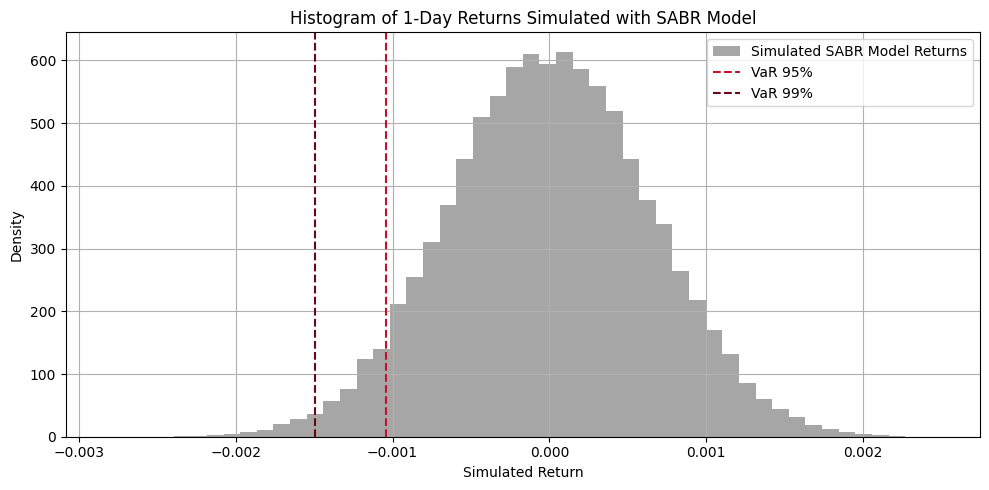

In [39]:
plt.figure(figsize=(10, 5))
plt.hist(returns_sabr, bins=50, density=True, alpha=0.7, color='gray', label='Simulated SABR Model Returns')
plt.axvline(-VaR_95_sabr / S0, color='#c70e2d', linestyle='--', label='VaR 95%')
plt.axvline(-VaR_99_sabr / S0, color='#68071a', linestyle='--', label='VaR 99%')
plt.title("Histogram of 1-Day Returns Simulated with SABR Model")
plt.xlabel("Simulated Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Histogram_of_1-Day_Returns_Simulated_with_SABR_Model.png", dpi=300, bbox_inches='tight')
plt.show()

## Model Comparisons and Sensitivity Analysis

This section compares the performance of the four volatility models—Realized (Historical), Merton, Kou, Rough Volatility, and SABR—in terms of their estimated Value at Risk (VaR) and their sensitivity to modeling assumptions.

### Comparison of Simulated Return Distributions

These two plots compare the full distribution and the left tail of 1-day returns simulated under each volatility model.

1. Overall Return Distributions

The plot displays the estimated return densities across the different models:

- Kou Jump clearly produces a distribution with fatter tails, reflecting the impact of frequent and sizable negative jumps.

- Merton Jump, Historical Volatility, and the Normal distribution yield very similar, relatively symmetric profiles with limited tail fattening, suggesting moderate risk at the 1-day horizon.

- Rough Volatility and SABR lead to distributions that are even more concentrated around the mean, indicating thinner tails and lower short-term dispersion.

> While all models are centered around similar means, Kou’s distribution stands out for its heavier tails, whereas stochastic volatility models such as Rough Vol. and SABR exhibit the lowest dispersion, suggesting limited short-term risk under current calibrations.

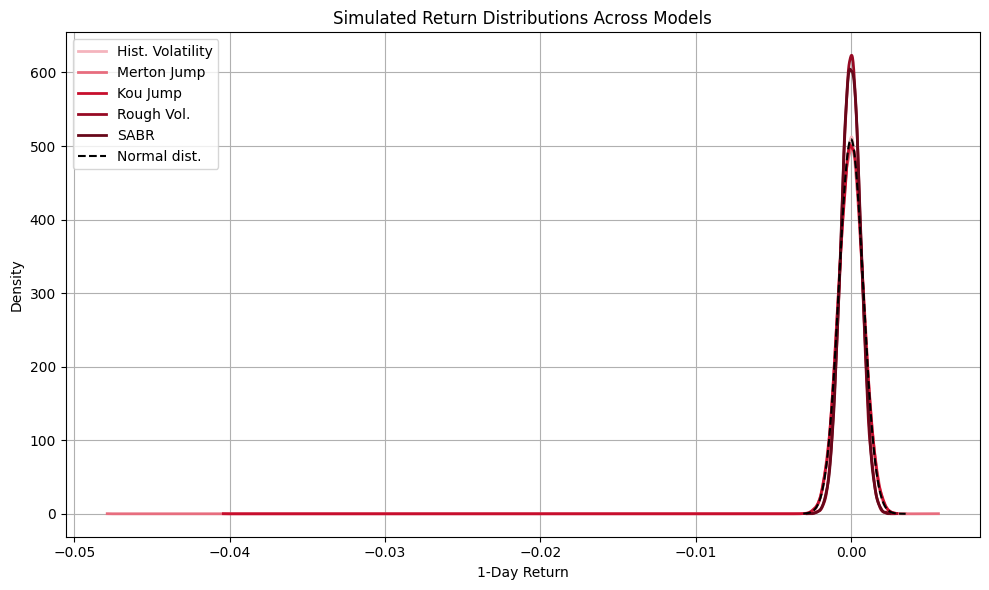

In [40]:
plt.figure(figsize=(10, 6))

for returns, label, color in zip(
    [returns_hist, returns_jump, returns_kou, returns_rough, returns_sabr],
    ['Hist. Volatility', 'Merton Jump', 'Kou Jump', 'Rough Vol.', 'SABR'],
    ['#f4b4bd', '#e76d7e', '#c70e2d', '#970a24', '#68071a']
):
    kde = gaussian_kde(returns)
    x_vals = np.linspace(min(returns), max(returns), 300)
    plt.plot(x_vals, kde(x_vals), label=label, lw=2, color=color)

mu_norm = returns_hist.mean()
sigma_norm = returns_hist.std()
x_norm = np.linspace(min(returns_hist), max(returns_hist), 300)
normal_pdf = norm.pdf(x_norm, loc=mu_norm, scale=sigma_norm)
plt.plot(x_norm, normal_pdf, linestyle='--', color='black', label='Normal dist.')

plt.title('Simulated Return Distributions Across Models')
plt.xlabel('1-Day Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Simulated_Return_Distributions_Across_Models.png", dpi=300, bbox_inches='tight')
plt.show()

2. Left-Tail Behavior (Zoomed-In View)

This zoomed-in plot focuses on the left tail of the return distributions, allowing a closer look at downside risk:

- Kou Jump shows the fattest left tail, indicating a higher probability of large negative returns due to its double-exponential jump structure.

- Merton Jump, Historical Volatility, and the Normal distribution exhibit nearly overlapping curves, with moderate tail thickness and no significant deviations.

- Rough Volatility and especially SABR present the thinnest tails, with densities decaying quickly, which translates into lower estimated downside risk.

> These results confirm that jump models—particularly Kou—capture extreme risk better, while stochastic volatility models under current calibration tend to underestimate tail risk in the short term.

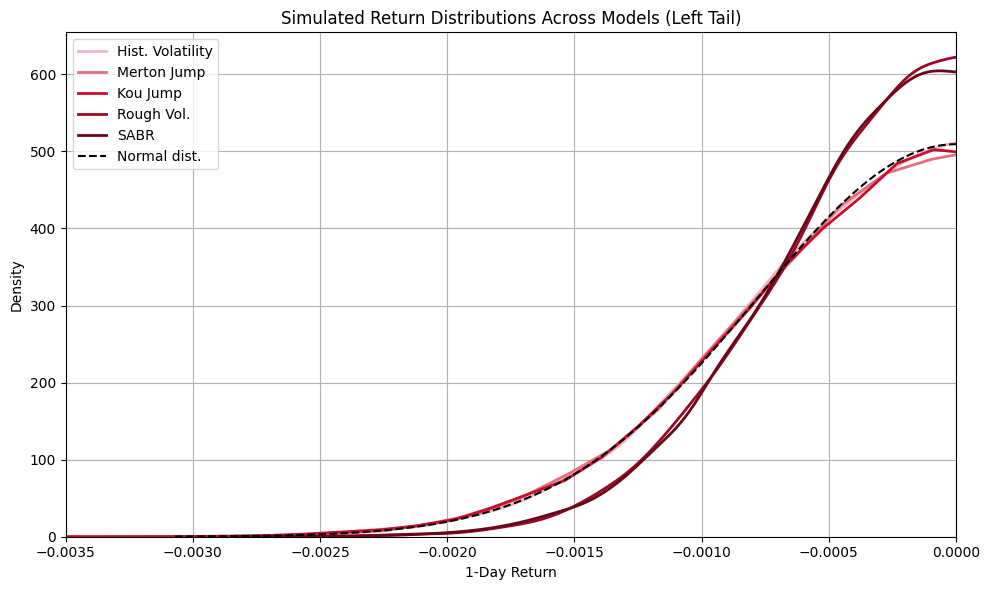

In [41]:
plt.figure(figsize=(10, 6))

for returns, label, color in zip(
    [returns_hist, returns_jump, returns_kou, returns_rough, returns_sabr],
    ['Hist. Volatility', 'Merton Jump', 'Kou Jump', 'Rough Vol.', 'SABR'],
    ['#f4b4bd', '#e76d7e', '#c70e2d', '#970a24', '#68071a']
):
    kde = gaussian_kde(returns)
    x_vals = np.linspace(min(returns), max(returns), 300)
    plt.plot(x_vals, kde(x_vals), label=label, lw=2, color=color)

mu_norm = returns_hist.mean()
sigma_norm = returns_hist.std()
x_norm = np.linspace(min(returns_hist), max(returns_hist), 300)
normal_pdf = norm.pdf(x_norm, loc=mu_norm, scale=sigma_norm)
plt.plot(x_norm, normal_pdf, linestyle='--', color='black', label='Normal dist.')

plt.xlim(-0.0035, 0.00)
plt.ylim(bottom=0)

plt.title('Simulated Return Distributions Across Models (Left Tail)')
plt.xlabel('1-Day Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results/Simulated_Return_Distributions_Across_Models_(Left Tail).png", dpi=300, bbox_inches='tight')
plt.show()

### Summary Table – VaR and Kurtosis Comparison

The table below reports the Value at Risk (VaR) at 95% and 99% confidence levels for each model, along with the kurtosis of the simulated return distributions:

- Kou Jump yields the highest VaR at both confidence levels, as well as an extremely elevated kurtosis, reflecting its ability to capture extreme events and heavy-tailed behavior.

- Historical Volatility and Merton Jump produce very similar VaR values and moderate kurtosis, indicating only limited tail risk amplification in the Merton model under current parameters.

- Rough Volatility and SABR models generate noticeably lower VaR estimates, with thin tails and kurtosis levels close to the normal benchmark. This aligns with previous visualizations showing sharper     decay in the left tail and suggests that stochastic volatility models, in this context, may understate short-term downside risk.

In [42]:
summary = pd.DataFrame({
    'Model': ['Hist. Volatility', 'Merton Jump', 'Kou Jump', 'Rough Vol.', 'SABR'],
    'VaR 95%': [
        -np.percentile(returns_hist, 5) * S0,
        -np.percentile(returns_jump, 5) * S0,
        -np.percentile(returns_kou, 5) * S0,
        -np.percentile(returns_rough, 5) * S0,
        -np.percentile(returns_sabr, 5) * S0
    ],
    'VaR 99%': [
        -np.percentile(returns_hist, 1) * S0,
        -np.percentile(returns_jump, 1) * S0,
        -np.percentile(returns_kou, 1) * S0,
        -np.percentile(returns_rough, 1) * S0,
        -np.percentile(returns_sabr, 1) * S0
    ],
    'Kurtosis': [
        kurtosis(returns_hist, fisher=False),
        kurtosis(returns_jump, fisher=False),
        kurtosis(returns_kou, fisher=False),
        kurtosis(returns_rough, fisher=False),
        kurtosis(returns_sabr, fisher=False)
    ]
})

print(summary)

              Model   VaR 95%   VaR 99%    Kurtosis
0  Hist. Volatility  0.126995  0.183374    3.006823
1       Merton Jump  0.129072  0.181000  362.927177
2          Kou Jump  0.128622  0.183914  228.232127
3        Rough Vol.  0.105046  0.146988    3.038346
4              SABR  0.104443  0.149471    2.962336


### Sensitivity Analysis

While advanced models like Rough Volatility and SABR incorporate sophisticated features such as stochastic dynamics and memory effects, their baseline calibrations did not yield significantly different VaR estimates compared to the historical volatility model—at least over a one-day horizon.

To assess whether this outcome reflects intrinsic model limitations or simply the effect of parameter choices, we explore the sensitivity of each model’s VaR estimates to key inputs:

- **Historical Volatility model**

    We vary the rolling window used to estimate volatility: 1 week, 1 month, 3 months, 6 months and 1 year.

- **Merton and Kou jump-diffusion models**

    We adjust the threshold for identifying jumps in the return distribution: 1.5σ, 2.0σ, 2.5σ and 3.0σ.

- **Rough Volatility model**

    We test the impact of using different rolling windows to estimate the parameters: $\xi$ (mean volatility), $\nu$ (volatility of volatility), and $H$ (Hurst exponent) (1W, 1M, 3M, 6M, 1Y)

- **SABR model**

    We vary the rolling window lengths used to compute the realized volatility series and its first differences $\Delta \sigma$, which are used to estimate $\xi_0$, $\nu$, and $\rho$.

By testing alternative configurations, we assess each model’s robustness to calibration uncertainty and its ability to reflect higher tail risk under more extreme or volatile market conditions.

> This analysis also acts as a stress test of model flexibility: a robust volatility model should not only replicate normal market behavior, but also capture shifts in risk when volatility becomes more erratic or when asset prices exhibit discontinuities.

#### Historical Volatility

This code computes the 95% and 99% Value at Risk (VaR) by simulating future returns under a geometric Brownian motion model. Volatility is estimated using rolling standard deviations over different window sizes (5, 20, 60, 120, and 250 days). For each case, VaR is calculated from the lower percentiles of the simulated returns.

In [58]:
window_sizes = [5, 20, 60, 120, 250]
hist_vol_sensitivity_results = []

for w in window_sizes:
    sigma_w = sp500_data["Log_return"].rolling(window=w).std().iloc[-1]
    Z = np.random.normal(0, 1, 10000)
    returns_hist_sens = (S0 * np.exp((mu - 0.5 * sigma_w**2) * T + sigma_w * np.sqrt(T) * Z) - S0) / S0
    VaR_95 = -np.percentile(returns_hist_sens, 5) * S0
    VaR_99 = -np.percentile(returns_hist_sens, 1) * S0

    hist_vol_sensitivity_results.append({
        'Window Size (days)': w,
        'Sigma (volatility)': sigma_w,
        'VaR_95_hist': VaR_95,
        'VaR_99_hist': VaR_99
    })

# Convert to DataFrame
hist_vol_sensitivity_df = pd.DataFrame(hist_vol_sensitivity_results)
print(hist_vol_sensitivity_df)



   Window Size (days)  Sigma (volatility)  VaR_95_hist  VaR_99_hist
0                   5            0.015008     0.153340     0.215155
1                  20            0.030443     0.322655     0.448011
2                  60            0.019257     0.196126     0.273271
3                 120            0.014936     0.156318     0.217997
4                 250            0.011954     0.121601     0.168748


> The plot shows that VaR estimates vary significantly with the volatility window size. Generally, shorter windows like 20 days react more to recent market shocks, leading to higher VaRs. However, the 5-day VaR is lower — likely because recent market volatility has calmed down, and such a short window fails to capture earlier turbulence (e.g., due to tariff-related news). This highlights the limitations of very short windows, which may miss recent volatility spikes if they fall just outside the estimation window.

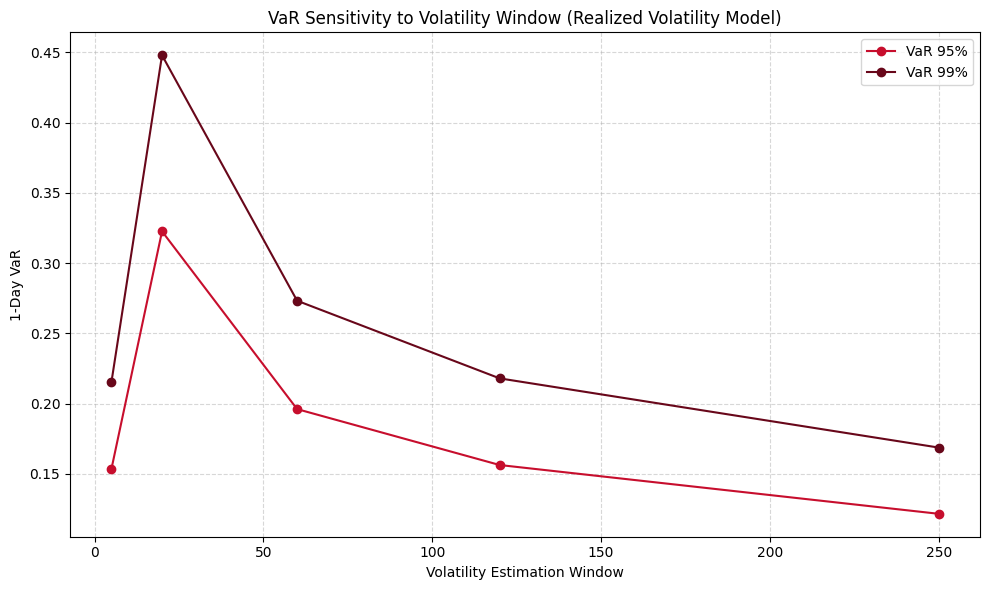

In [97]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(hist_vol_sensitivity_df['Window Size (days)'], hist_vol_sensitivity_df['VaR_95_hist'], marker='o', color='#c70e2d', label='VaR 95%')
plt.plot(hist_vol_sensitivity_df['Window Size (days)'], hist_vol_sensitivity_df['VaR_99_hist'], marker='o', color='#68071a', label='VaR 99%')

plt.title('VaR Sensitivity to Volatility Window (Realized Volatility Model)')
plt.xlabel('Volatility Estimation Window')
plt.ylabel('1-Day VaR')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(r"results/VaR_Sensitivity_to_Volatility_Window_(Realized Volatility).png", dpi=300, bbox_inches='tight')
plt.show()

#### Jump-Diffusion Models (Merton)

This code tests the sensitivity of Merton’s jump diffusion model to different jump detection thresholds (from 1.5σ to 3.0σ). For each threshold:

- It identifies jumps as returns that exceed the threshold in absolute value.

- Estimates jump intensity (λ), average jump size (μ_J), and jump volatility (σ_J).

- Simulates asset returns including both diffusion and jump components.

- Computes 95% and 99% Value at Risk (VaR) based on the simulated return distribution.

As the threshold increases:

- Fewer jumps are detected → λ decreases.

- The magnitude and volatility of jumps (μ_J, σ_J) tend to increase.

- VaR estimates (especially VaR_99) remain relatively stable, but slightly increase at higher thresholds due to larger individual jumps, despite being fewer.

> This shows that VaR under the Merton model is not overly sensitive to the exact jump threshold, although assumptions about jump frequency and size still have a noticeable impact, especially at extreme confidence levels.

In [81]:
returns = sp500_data['Log_return'].dropna()

thresholds = [1.5, 2.0, 2.5, 3.0]
merton_sensitivity_results = []

for th in thresholds:
    jumps = returns[np.abs(returns) > th * sigma]
     
    if len(jumps) > 0:
        lambda_jump = len(jumps) / len(returns)
        mu_J = jumps.mean()
        sigma_J = jumps.std()

        # Simulate jump component
        N_jumps = np.random.poisson(lambda_jump * T, n_sim)
        J = np.random.normal(mu_J, sigma_J, n_sim) * N_jumps

        # Simulate diffusion component
        Z = np.random.normal(0, 1, n_sim)
        S_jump = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z + J)
        returns_jump = (S_jump - S0) / S0

        VaR_95 = -np.percentile(returns_jump, 5) * S0
        VaR_99 = -np.percentile(returns_jump, 1) * S0
    else:
        lambda_jump = mu_J = sigma_J = VaR_95 = VaR_99 = np.nan
    
    merton_sensitivity_results.append({
        'Threshold': f'{th}σ',
        'Detected Jumps': len(jumps),
        'λ (jumps/day)': lambda_jump,
        'μ_J': mu_J,
        'σ_J': sigma_J,
        'VaR_95_merton': VaR_95,
        'VaR_99_merton': VaR_99
    })

# Convert to DataFrame
merton_sensitivity_df = pd.DataFrame(merton_sensitivity_results)
print(merton_sensitivity_df)

  Threshold  Detected Jumps  λ (jumps/day)       μ_J       σ_J  VaR_95_merton  \
0      1.5σ             429       0.088746 -0.004365  0.034221       0.127744   
1      2.0σ             228       0.047166 -0.007367  0.042127       0.127807   
2      2.5σ             130       0.026893 -0.009041  0.050452       0.128596   
3      3.0σ              82       0.016963 -0.006965  0.058771       0.128119   

   VaR_99_merton  
0       0.179606  
1       0.181383  
2       0.181958  
3       0.182354  


This chart shows how 1-day VaR at the 95% and 99% confidence levels changes depending on the threshold used to detect jumps in the Merton model.

- The x-axis shows the jump detection threshold (in multiples of standard deviation, σ).

- The y-axis shows the corresponding VaR values.

> VaR estimates remain relatively stable across thresholds, especially for the 95% level. However, at the 99% level, VaR slightly increases with higher thresholds, likely due to fewer but larger jumps being captured. This indicates that while jump frequency decreases with stricter thresholds, the impact of extreme events becomes more significant at high confidence levels.

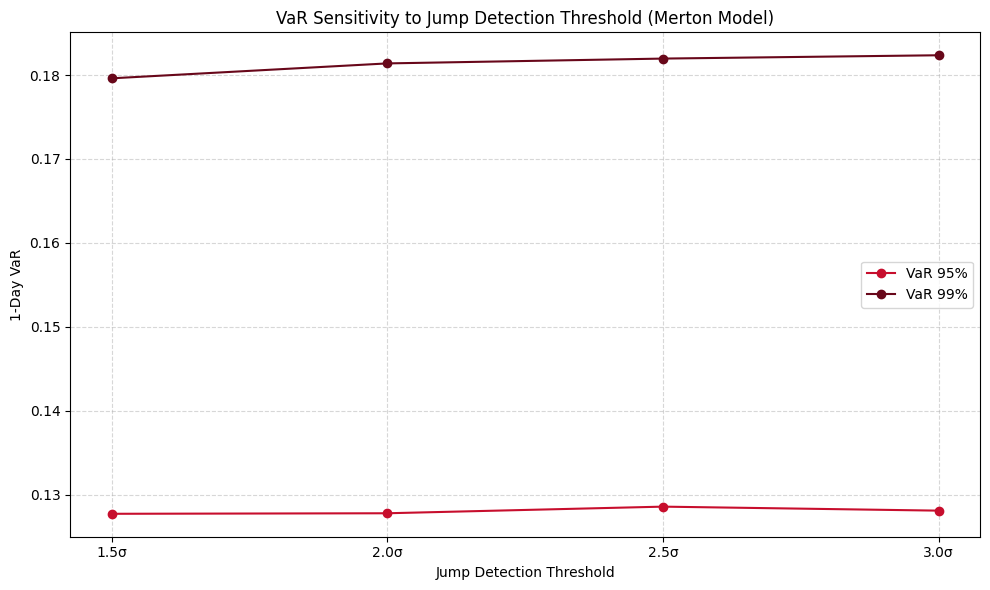

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(merton_sensitivity_df['Threshold'], merton_sensitivity_df['VaR_95_merton'], marker='o', label='VaR 95%', color='#c70e2d')
plt.plot(merton_sensitivity_df['Threshold'], merton_sensitivity_df['VaR_99_merton'], marker='o', label='VaR 99%', color='#68071a')

plt.title("VaR Sensitivity to Jump Detection Threshold (Merton Model)")
plt.xlabel("Jump Detection Threshold")
plt.ylabel("1-Day VaR")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(r"results/VaR_Sensitivity_to_Jump_Detection_Threshold_(Merton Model).png", dpi=300, bbox_inches='tight')
plt.show()

This chart shows how the number and size of detected jumps vary with the jump detection threshold.

- The red bars indicate the number of jumps detected (left axis).

- The black line shows the average jump size (μ_J), and the green line shows its standard deviation (σ_J) (right axis).

As the threshold increases:

- The number of detected jumps decreases.

- The standard deviation of jump sizes (σ_J) increases, indicating that larger and more volatile jumps are captured.

- The average jump size (μ_J) remains negative, but does not show a consistent increase in magnitude — it slightly rebounds at the 3.0σ level.

> Changing the threshold significantly affects the quantity and variability of detected jumps, but has limited impact on average jump size. Therefore, while adjusting the threshold refines model calibration, its effect on overall risk metrics (like VaR) is moderate — suggesting the model is relatively robust to reasonable threshold choices.

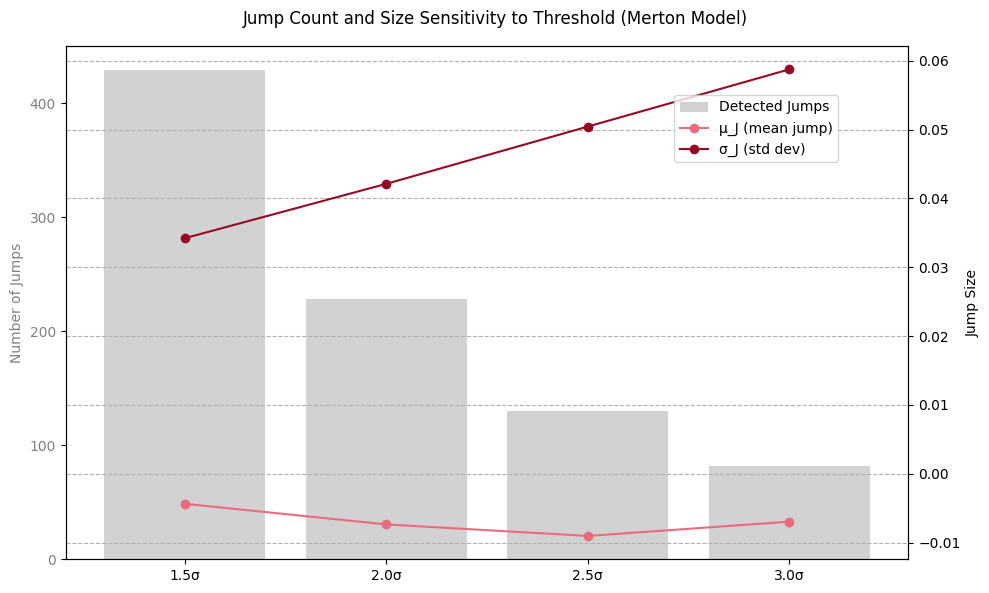

In [83]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Jumps detected (bar)
ax1.bar(merton_sensitivity_df['Threshold'], merton_sensitivity_df['Detected Jumps'], 
        alpha=0.35, label='Detected Jumps', color='grey')
ax1.set_ylabel('Number of Jumps', color='gray')
ax1.tick_params(axis='y', labelcolor='grey')

# Twin axis for μ_J and σ_J
ax2 = ax1.twinx()
ax2.plot(merton_sensitivity_df['Threshold'], merton_sensitivity_df['μ_J'], marker='o', label='μ_J (mean jump)', color='#e76d7e')
ax2.plot(merton_sensitivity_df['Threshold'], merton_sensitivity_df['σ_J'], marker='o', label='σ_J (std dev)', color='#970a24')
ax2.set_ylabel('Jump Size', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.suptitle("Jump Count and Size Sensitivity to Threshold (Merton Model)")
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()
plt.savefig(r"results/Jump Count and Size Sensitivity to Threshold (Merton Model).png", dpi=300, bbox_inches='tight')
plt.show()


#### Jump-Diffusion Models (Kou)

This code performs a sensitivity analysis of the Kou jump diffusion model by varying the threshold used to detect jumps in the return series.

- For each threshold (1.5σ to 3.0σ), it identifies jumps, separates positive and negative ones, and estimates:

    - λ: jump intensity (jumps per day),

    - p: probability of a positive jump,

    - η₁ and η₂: intensities of the exponential distributions for positive and negative jumps.

- Using these parameters, it simulates jumps with asymmetric exponential distributions and computes 1-day VaR at 95% and 99% confidence levels.

As the threshold increases:

- Fewer jumps are detected, leading to lower λ.

- η₁ and η₂ increase (i.e., mean jump sizes decrease), since higher thresholds capture only the most extreme moves.

- VaR values remain fairly stable, with slight variations across thresholds.

> Changing the jump detection threshold impacts the Kou model parameters but has limited influence on VaR estimates. This suggests the model is relatively robust to threshold choice, capturing jump asymmetry effectively even with fewer extreme observations.

In [84]:
def simulate_kou_jumps(n, lmbda, dt, p_kou, eta1_kou, eta2_kou):
    N = np.random.poisson(lmbda * dt, n)
    J = np.zeros(n)
    for i in range(n):
        for _ in range(N[i]):
            if np.random.rand() < p_kou:
                J[i] += np.random.exponential(1 / eta1_kou)
            else:
                J[i] -= np.random.exponential(1 / eta2_kou)
    return J

# Sensitivity analysis across thresholds
kou_sensitivity_results = []
thresholds = [1.5, 2.0, 2.5, 3.0]

for th in thresholds:
    jumps = returns[np.abs(returns) > th * sigma]
    jumps_pos = jumps[jumps > 0]
    jumps_neg = jumps[jumps < 0]

    if len(jumps_pos) > 0 and len(jumps_neg) > 0:
        lambda_kou = len(jumps) / len(returns)
        p_kou = len(jumps_pos) / len(jumps)
        eta1_kou = 1 / jumps_pos.mean()
        eta2_kou = 1 / abs(jumps_neg.mean())

        # Simulate jump component
        J_kou = simulate_kou_jumps(n_sim, lambda_kou, T, p_kou, eta1_kou, eta2_kou)

        # Simulate asset paths
        Z = np.random.normal(0, 1, n_sim)
        S_kou = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z + J_kou)
        returns_kou = (S_kou - S0) / S0

        VaR_95 = -np.percentile(returns_kou, 5) * S0
        VaR_99 = -np.percentile(returns_kou, 1) * S0
    else:
        lambda_kou = p_kou = eta1_kou = eta2_kou = VaR_95 = VaR_99 = np.nan

    kou_sensitivity_results.append({
        'Threshold': f'{th}σ',
        'Detected Jumps': len(jumps),
        'λ (jumps/day)': lambda_kou,
        'p': p_kou,
        'η₁ (pos intensity)': eta1_kou,
        'η₂ (neg intensity)': eta2_kou,
        'VaR_95_kou': VaR_95,
        'VaR_99_kou': VaR_99
    })

# Convert to DataFrame
kou_sensitivity_df = pd.DataFrame(kou_sensitivity_results)
print(kou_sensitivity_df)

  Threshold  Detected Jumps  λ (jumps/day)         p  η₁ (pos intensity)  \
0      1.5σ             429       0.088746  0.435897           32.876083   
1      2.0σ             228       0.047166  0.399123           25.159295   
2      2.5σ             130       0.026893  0.392308           20.353612   
3      3.0σ              82       0.016963  0.439024           18.049044   

   η₂ (neg intensity)  VaR_95_kou  VaR_99_kou  
0           32.007154    0.128070    0.181335  
1           25.865317    0.130552    0.183056  
2           21.461623    0.129603    0.182521  
3           17.928642    0.128982    0.184440  


This chart shows the sensitivity of 1-day VaR (95% and 99%) to different jump detection thresholds in the Kou model.

- The x-axis shows the jump threshold (from 1.5σ to 3.0σ).

- The y-axis shows the corresponding VaR values.

- The gray line represents VaR 95%, and the blue line VaR 99%.

> VaR estimates remain relatively stable across thresholds. The 99% VaR shows a slight peak at 2.0σ before decreasing, while the 95% VaR is nearly flat.
This indicates that the Kou model is robust to the choice of jump threshold, capturing risk effectively even with fewer detected jumps.



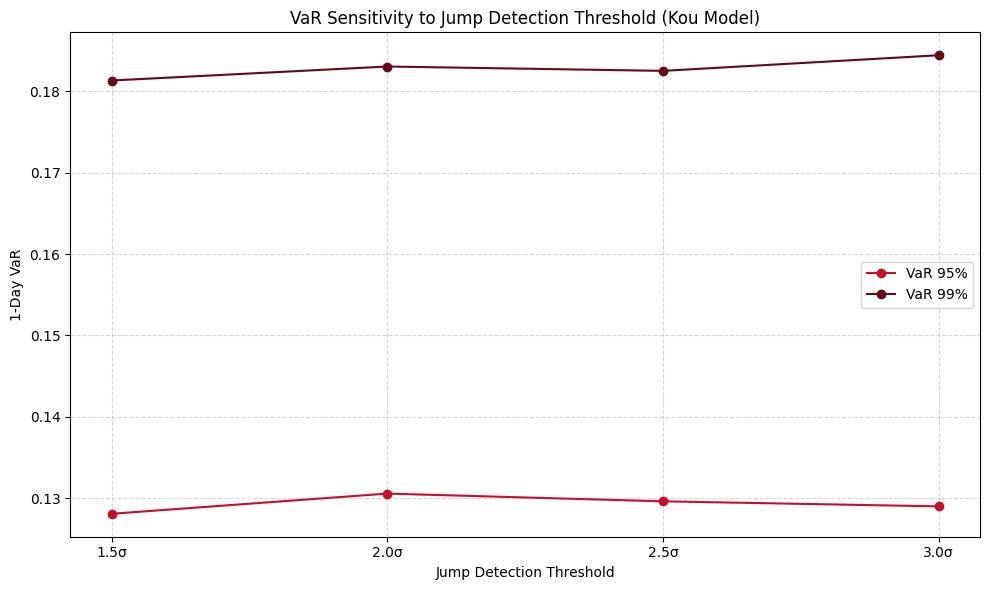

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(kou_sensitivity_df['Threshold'], kou_sensitivity_df['VaR_95_kou'], marker='o', label='VaR 95%', color='#c70e2d')
plt.plot(kou_sensitivity_df['Threshold'], kou_sensitivity_df['VaR_99_kou'], marker='o', label='VaR 99%', color='#68071a')

plt.title("VaR Sensitivity to Jump Detection Threshold (Kou Model)")
plt.xlabel("Jump Detection Threshold")
plt.ylabel("1-Day VaR")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(r"results/VaR_Sensitivity_to_Jump_Detection_Threshold_(Kou Model).png", dpi=300, bbox_inches='tight')
plt.show()

This chart shows how the number of detected jumps and their average size (in the Kou model) vary with the jump detection threshold.

- Red bars (left axis): number of detected jumps.

- Black line: mean positive jump size $1/η_1$.

- Green line: mean negative jump size $1/η_2$, both on the right axis.

As the threshold increases:

- The number of detected jumps decreases sharply.

- Both positive and negative average jump sizes increase, as only larger jumps exceed higher thresholds.

> Increasing the threshold leads to fewer but larger detected jumps, confirming that the Kou model effectively captures jump asymmetry — and that threshold choice directly influences the balance between frequency and magnitude of identified jumps.

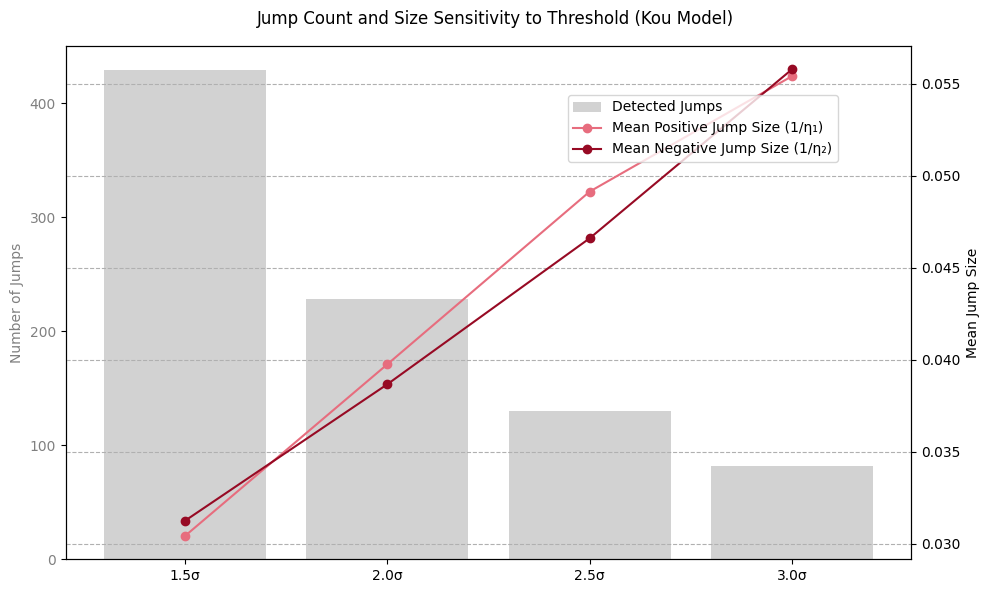

In [86]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Jumps detected (bar plot)
ax1.bar(kou_sensitivity_df['Threshold'], kou_sensitivity_df['Detected Jumps'], 
        alpha=0.35, label='Detected Jumps', color='gray')
ax1.set_ylabel('Number of Jumps', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Twin axis for mean jump sizes (1/η₁ and 1/η₂)
ax2 = ax1.twinx()
ax2.plot(kou_sensitivity_df['Threshold'], 1 / kou_sensitivity_df['η₁ (pos intensity)'], 
         marker='o', label='Mean Positive Jump Size (1/η₁)', color='#e76d7e')
ax2.plot(kou_sensitivity_df['Threshold'], 1 / kou_sensitivity_df['η₂ (neg intensity)'], 
         marker='o', label='Mean Negative Jump Size (1/η₂)', color='#970a24')
ax2.set_ylabel('Mean Jump Size', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.suptitle("Jump Count and Size Sensitivity to Threshold (Kou Model)")
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()
plt.savefig(r"results/Jump_Count_and_Size_Sensitivity_to_Threshold_(Kou Model).png", dpi=300, bbox_inches='tight')
plt.show()

#### Rough Model

This code evaluates the sensitivity of Value at Risk (VaR) under a rough volatility model, using realized volatility estimated over different rolling windows (5d to 250d).

For each window, it calculates:

- ξ₀: average volatility,

- ν: volatility of volatility,

- H: Hurst exponent (captures the “roughness” of the volatility path).

It then simulates asset returns using a fractional Brownian motion (FBM) with the estimated Hurst exponent and computes 1-day VaR at 95% and 99% levels.

As the volatility window increases:

- ξ₀ and H increase → volatility becomes smoother and less noisy.

- ν (vol of vol) decreases → short-term volatility fluctuations are smoothed out.

> As a result, VaR values increase, especially at the 99% level, reflecting the higher long-term volatility captured by longer windows.

In [87]:
rough_sensitivity_results = []
vol_windows = ["5d", "20d", "60d", "120d", "250d"]

for window in vol_windows:
    vol_series = sp500_data[f"realized_volatility_{window}"].dropna()

    # Calibration
    xi_0 = vol_series.mean()
    nu = vol_series.std()
    H, _, _ = compute_Hc(vol_series, kind='price')

    # Simulation
    S_rough = np.zeros(n_sim)
    returns_rough = np.zeros(n_sim)

    for i in range(n_sim):
        f = FBM(n=1, hurst=H, length=T, method='daviesharte')
        W_H = f.fbm()[1]
        sigma_t = xi_0 * np.exp(nu * W_H - 0.5 * (nu**2) * T**(2 * H))
        Z = np.random.normal(0, 1)
        S1 = S0 * np.exp((mu - 0.5 * sigma_t**2) * T + sigma_t * np.sqrt(T) * Z)
        S_rough[i] = S1
        returns_rough[i] = (S1 - S0) / S0

    VaR_95 = -np.percentile(returns_rough, 5) * S0
    VaR_99 = -np.percentile(returns_rough, 1) * S0

    rough_sensitivity_results.append({
        'Vol Window': window,
        'ξ₀ (mean vol)': xi_0,
        'ν (vol of vol)': nu,
        'H': H,
        'VaR_95_rough': VaR_95,
        'VaR_99_rough': VaR_99
    })

# Convertir a DataFrame
rough_sensitivity_df = pd.DataFrame(rough_sensitivity_results)
print(rough_sensitivity_df)

  Vol Window  ξ₀ (mean vol)  ν (vol of vol)         H  VaR_95_rough  \
0         5d       0.009701        0.008278  0.741523      0.100372   
1        20d       0.010175        0.007179  0.704113      0.104312   
2        60d       0.010540        0.006547  0.778132      0.109468   
3       120d       0.010844        0.006060  0.804229      0.112625   
4       250d       0.011289        0.005404  0.835158      0.116146   

   VaR_99_rough  
0      0.141522  
1      0.147217  
2      0.154398  
3      0.159316  
4      0.163932  


This chart shows how 1-day VaR at 95% and 99% confidence levels evolves as the volatility estimation window increases under the rough volatility model.

- The x-axis represents the window used to compute realized volatility (from 5 to 250 days).

- The y-axis shows the corresponding VaR values.

- The gray line is VaR 95%, and the blue line is VaR 99%.

VaR increases with longer volatility windows, as the model incorporates higher average volatility and greater persistence (Hurst exponent).

> This suggests that longer windows capture more structural risk, leading to more conservative VaR estimates under rough volatility dynamics.

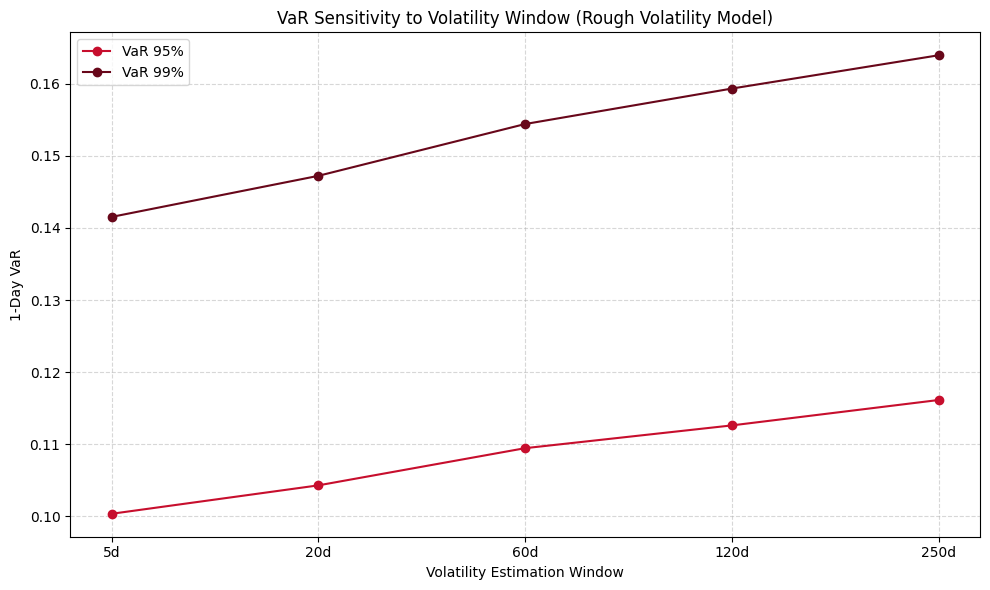

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(rough_sensitivity_df['Vol Window'], rough_sensitivity_df['VaR_95_rough'], 
         marker='o', label='VaR 95%', color='#c70e2d')
plt.plot(rough_sensitivity_df['Vol Window'], rough_sensitivity_df['VaR_99_rough'], 
         marker='o', label='VaR 99%', color='#68071a')

plt.title("VaR Sensitivity to Volatility Window (Rough Volatility Model)")
plt.xlabel("Volatility Estimation Window")
plt.ylabel("1-Day VaR")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(r"results/VaR_Sensitivity_to_Volatility_Window_(Rough Volatility Model).png", dpi=300, bbox_inches='tight')
plt.show()

This chart shows how the key parameters of the rough volatility model vary depending on the volatility estimation window.

- Blue bars (left y-axis): mean volatility $𝜉_0$.

- Black line: volatility of volatility $𝜈$ (right y-axis).

- Green line: Hurst exponent $𝐻$ (right y-axis), indicating the roughness of volatility paths.

As the volatility window increases:

- $𝜉_0$ and $𝐻$ increase, suggesting higher average volatility and smoother (less rough) dynamics.

- $𝜈$ decreases, meaning short-term volatility fluctuations become less pronounced.

> This highlights that longer windows capture persistent, low-frequency volatility, which increases perceived risk but reduces short-term variability.

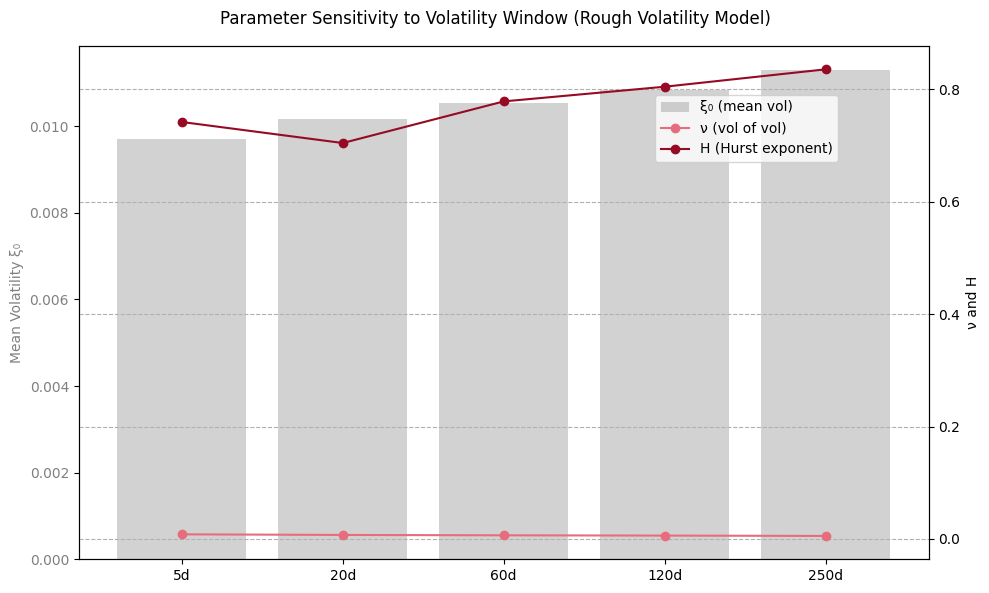

In [89]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot: ξ₀ (mean volatility)
ax1.bar(rough_sensitivity_df['Vol Window'], rough_sensitivity_df['ξ₀ (mean vol)'], 
        alpha=0.35, label='ξ₀ (mean vol)', color='gray')
ax1.set_ylabel('Mean Volatility ξ₀', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Twin axis: ν and H
ax2 = ax1.twinx()
ax2.plot(rough_sensitivity_df['Vol Window'], rough_sensitivity_df['ν (vol of vol)'], 
         marker='o', label='ν (vol of vol)', color='#e76d7e')
ax2.plot(rough_sensitivity_df['Vol Window'], rough_sensitivity_df['H'], 
         marker='o', label='H (Hurst exponent)', color='#970a24')
ax2.set_ylabel('ν and H', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.suptitle("Parameter Sensitivity to Volatility Window (Rough Volatility Model)")
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()
plt.savefig(r"results/Parameter_Sensitivity_to_Volatility_Window_(Rough Volatility Model).png", dpi=300, bbox_inches='tight')
plt.show()


#### SABR Model

This code performs a sensitivity analysis of VaR under the SABR model by varying the rolling window used to estimate historical volatility.

For each window:

- It computes the mean volatility $𝜉_0$, volatility of volatility $𝜈$, and the correlation $𝜌$ between asset returns and volatility changes.

- Then, it simulates asset returns using the SABR dynamics, where volatility follows a lognormal process correlated with asset returns.

- Finally, it computes VaR at 95% and 99% confidence levels based on the simulated return distribution.

As the volatility window increases:

- $𝜉_0$ increases (volatility is higher on average),

- $𝜈$ decreases (vol of vol becomes more stable),

- $𝜌$ becomes more negatively correlated, suggesting returns and volatility changes are increasingly inverse-related,

- VaR estimates increase, reflecting higher risk as longer windows incorporate more persistent and structural volatility.

> VaR under the SABR model is sensitive to the volatility estimation window. Longer windows lead to higher and more conservative VaR estimates due to increasing average volatility and stronger negative return-volatility correlation — a key feature of the SABR framework.

In [90]:
sabr_sensitivity_results = []
vol_windows = ["5d", "20d", "60d", "120d", "250d"]

log_ret = sp500_data["Log_return"]

for window in vol_windows:
    vol_series = sp500_data[f"realized_volatility_{window}"].dropna()
    delta_vol = vol_series.diff()

    # Alinear ambas series para la correlación
    aligned = pd.concat([log_ret, delta_vol], axis=1).dropna()
    rho = np.corrcoef(aligned.iloc[:, 0], aligned.iloc[:, 1])[0, 1]

    xi_0 = vol_series.mean()
    nu = vol_series.std()

    # Simulación
    S_sabr = np.zeros(n_sim)
    returns_sabr = np.zeros(n_sim)

    for i in range(n_sim):
        Z1 = np.random.normal(0, 1)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1)

        sigma_1 = xi_0 * np.exp(nu * Z2 * np.sqrt(T) - 0.5 * (nu**2) * T)
        S1 = S0 * np.exp(-0.5 * (sigma_1**2) * T + sigma_1 * np.sqrt(T) * Z1)
        S_sabr[i] = S1
        returns_sabr[i] = (S1 - S0) / S0

    VaR_95 = -np.percentile(returns_sabr, 5) * S0
    VaR_99 = -np.percentile(returns_sabr, 1) * S0

    sabr_sensitivity_results.append({
        'Vol Window': window,
        'ξ₀ (mean vol)': xi_0,
        'ν (vol of vol)': nu,
        'ρ': rho,
        'VaR_95_sabr': VaR_95,
        'VaR_99_sabr': VaR_99
    })

# Convertir a DataFrame
sabr_sensitivity_df = pd.DataFrame(sabr_sensitivity_results)
print(sabr_sensitivity_df)


  Vol Window  ξ₀ (mean vol)  ν (vol of vol)         ρ  VaR_95_sabr  \
0         5d       0.009701        0.008278  0.030155     0.099095   
1        20d       0.010175        0.007179 -0.083534     0.105197   
2        60d       0.010540        0.006547 -0.086665     0.110648   
3       120d       0.010844        0.006060 -0.128173     0.113297   
4       250d       0.011289        0.005404 -0.111744     0.116939   

   VaR_99_sabr  
0     0.142100  
1     0.149663  
2     0.154675  
3     0.160615  
4     0.167712  


This chart shows how 1-day VaR at 95% and 99% confidence levels evolves with different volatility estimation windows under the SABR log-normal model.

- The x-axis shows the window used to compute realized volatility (from 5 to 250 days).

- The y-axis shows the simulated VaR values.

- The gray line represents VaR 95%, and the blue line VaR 99%.

VaR increases with longer volatility windows, reflecting the impact of higher average volatility and stronger negative correlation between returns and volatility.

> This suggests that the SABR model produces more conservative risk estimates when calibrated with longer-term volatility, capturing persistent risk more effectively.

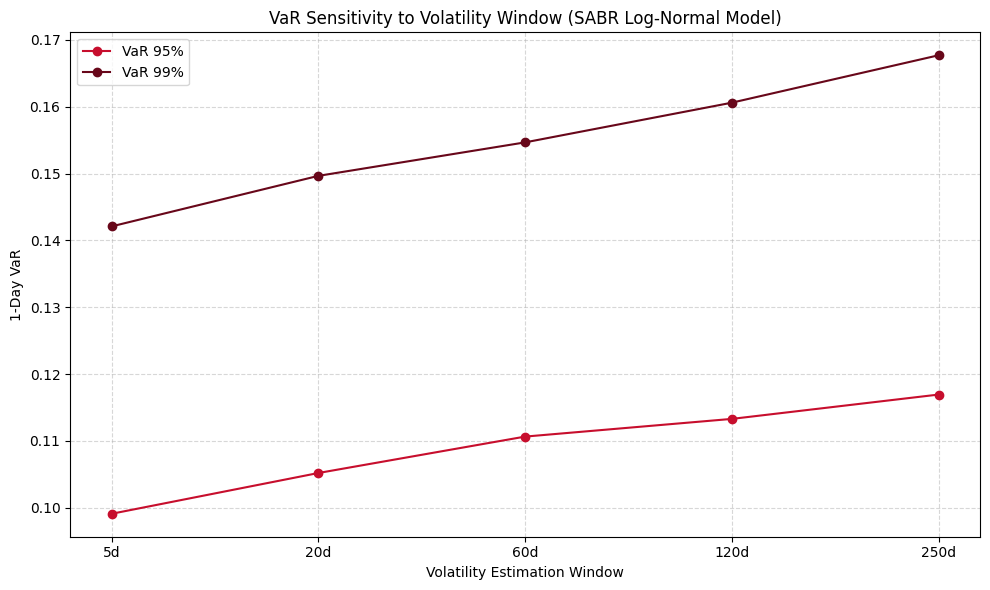

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(sabr_sensitivity_df['Vol Window'], sabr_sensitivity_df['VaR_95_sabr'], 
         marker='o', label='VaR 95%', color='#c70e2d')
plt.plot(sabr_sensitivity_df['Vol Window'], sabr_sensitivity_df['VaR_99_sabr'], 
         marker='o', label='VaR 99%', color='#68071a')

plt.title("VaR Sensitivity to Volatility Window (SABR Log-Normal Model)")
plt.xlabel("Volatility Estimation Window")
plt.ylabel("1-Day VaR")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(r"results/VaR_Sensitivity_to_Volatility_Window_(SABR Log-Normal Model).png", dpi=300, bbox_inches='tight')
plt.show()

This chart displays how key SABR model parameters vary with the volatility estimation window:

- Blue bars (left y-axis): mean volatility $𝜉_0$.

- Black line (right y-axis): volatility of volatility $𝜈$.

- Green line (right y-axis): correlation $𝜌$ between log returns and volatility changes.

As the window increases:

- $𝜉_0$ and $𝜈$ stay relatively stable.

- $𝜌$ becomes more negatively correlated, especially beyond the 20-day window.

> The negative correlation between returns and changes in volatility observed for longer windows is consistent with the leverage effect — where volatility tends to rise more strongly during price drops than it falls during price increases, resulting in a net inverse relationship over time.

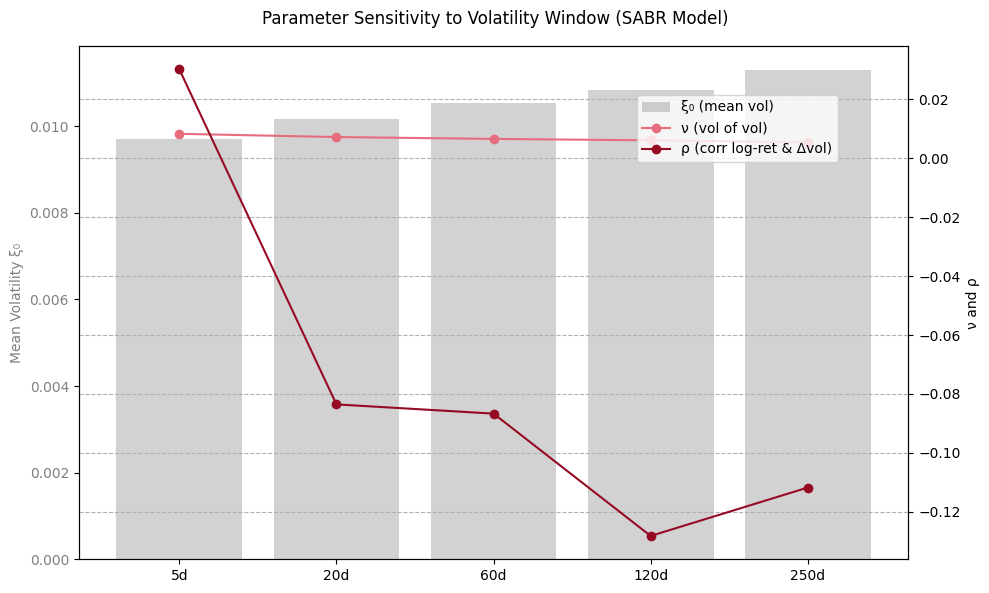

In [92]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot: ξ₀ (mean volatility)
ax1.bar(sabr_sensitivity_df['Vol Window'], sabr_sensitivity_df['ξ₀ (mean vol)'], 
        alpha=0.35, label='ξ₀ (mean vol)', color='gray')
ax1.set_ylabel('Mean Volatility ξ₀', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Twin axis: ν and ρ
ax2 = ax1.twinx()
ax2.plot(sabr_sensitivity_df['Vol Window'], sabr_sensitivity_df['ν (vol of vol)'], 
         marker='o', label='ν (vol of vol)', color='#e76d7e')
ax2.plot(sabr_sensitivity_df['Vol Window'], sabr_sensitivity_df['ρ'], 
         marker='o', label='ρ (corr log-ret & Δvol)', color='#970a24')
ax2.set_ylabel('ν and ρ', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.suptitle("Parameter Sensitivity to Volatility Window (SABR Model)")
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()
plt.savefig(r"results/Parameter_Sensitivity_to_Volatility_Window_(SABR Model).png", dpi=300, bbox_inches='tight')
plt.show()

### Summary table

In [93]:
# Historical Volatility DataFrame (corregido definitivamente)
hist_df = hist_vol_sensitivity_df.copy()
hist_df['Model'] = 'Historical Volatility'
hist_df = hist_df.rename(columns={'Window Size (days)': 'Sensitivity','VaR_95_hist':'VaR_95','VaR_99_hist':'VaR_99'})
hist_df['Kurtosis'] = kurtosis(returns_hist, fisher=False)
hist_df['Parameters'] = 'σ=' + hist_df['Sigma (volatility)'].round(4).astype(str)
hist_df = hist_df[['Model', 'Sensitivity', 'VaR_95', 'VaR_99', 'Kurtosis', 'Parameters']]

# Merton Jump
merton_df = merton_sensitivity_df.copy()
merton_df['Model'] = 'Merton Jump'
merton_df = merton_df.rename(columns={'Threshold': 'Sensitivity', 'VaR_95_merton':'VaR_95', 'VaR_99_merton':'VaR_99'})
merton_df['Kurtosis'] = kurtosis(returns_jump, fisher=False)
merton_df['Parameters'] = 'λ=' + merton_df['λ (jumps/day)'].round(4).astype(str) + \
                          ', μ_J=' + merton_df['μ_J'].round(4).astype(str) + \
                          ', σ_J=' + merton_df['σ_J'].round(4).astype(str)
merton_df = merton_df[['Model', 'Sensitivity', 'VaR_95', 'VaR_99', 'Kurtosis', 'Parameters']]

# Kou Jump
kou_df = kou_sensitivity_df.copy()
kou_df['Model'] = 'Kou Jump'
kou_df = kou_df.rename(columns={'Threshold': 'Sensitivity', 'VaR_95_kou':'VaR_95', 'VaR_99_kou':'VaR_99'})
kou_df['Kurtosis'] = kurtosis(returns_kou, fisher=False)
kou_df['Parameters'] = 'λ=' + kou_df['λ (jumps/day)'].round(4).astype(str) + \
                       ', p=' + kou_df['p'].round(4).astype(str) + \
                       ', η₁=' + kou_df['η₁ (pos intensity)'].round(4).astype(str) + \
                       ', η₂=' + kou_df['η₂ (neg intensity)'].round(4).astype(str)
kou_df = kou_df[['Model', 'Sensitivity', 'VaR_95', 'VaR_99', 'Kurtosis', 'Parameters']]

# Rough Volatility
rough_df = rough_sensitivity_df.copy()
rough_df['Model'] = 'Rough Vol.'
rough_df = rough_df.rename(columns={'Vol Window': 'Sensitivity', 'VaR_95_rough':'VaR_95', 'VaR_99_rough':'VaR_99'})
rough_df['Kurtosis'] = kurtosis(returns_rough, fisher=False)
rough_df['Parameters'] = 'ξ₀=' + rough_df['ξ₀ (mean vol)'].round(4).astype(str) + \
                         ', ν=' + rough_df['ν (vol of vol)'].round(4).astype(str) + \
                         ', H=' + rough_df['H'].round(4).astype(str)
rough_df = rough_df[['Model', 'Sensitivity', 'VaR_95', 'VaR_99', 'Kurtosis', 'Parameters']]

# SABR Model
sabr_df = sabr_sensitivity_df.copy()
sabr_df['Model'] = 'SABR'
sabr_df = sabr_df.rename(columns={'Vol Window': 'Sensitivity', 'VaR_95_sabr':'VaR_95', 'VaR_99_sabr':'VaR_99'})
sabr_df['Kurtosis'] = kurtosis(returns_sabr, fisher=False)
sabr_df['Parameters'] = 'ξ₀=' + sabr_df['ξ₀ (mean vol)'].round(4).astype(str) + \
                        ', ν=' + sabr_df['ν (vol of vol)'].round(4).astype(str) + \
                        ', ρ=' + sabr_df['ρ'].round(4).astype(str)
sabr_df = sabr_df[['Model', 'Sensitivity', 'VaR_95', 'VaR_99', 'Kurtosis', 'Parameters']]

# Concatenar todos los DataFrames con variables diferenciadas claramente
combined_summary_clean = pd.concat([hist_df, merton_df, kou_df, rough_df, sabr_df], 
                                   ignore_index=True)

# Mostrar resultado final
print(combined_summary_clean)

                    Model Sensitivity    VaR_95    VaR_99      Kurtosis  \
0   Historical Volatility           5  0.153340  0.215155      3.006823   
1   Historical Volatility          20  0.322655  0.448011      3.006823   
2   Historical Volatility          60  0.196126  0.273271      3.006823   
3   Historical Volatility         120  0.156318  0.217997      3.006823   
4   Historical Volatility         250  0.121601  0.168748      3.006823   
5             Merton Jump        1.5σ  0.127744  0.179606   1575.634273   
6             Merton Jump        2.0σ  0.127807  0.181383   1575.634273   
7             Merton Jump        2.5σ  0.128596  0.181958   1575.634273   
8             Merton Jump        3.0σ  0.128119  0.182354   1575.634273   
9                Kou Jump        1.5σ  0.128070  0.181335  16711.394725   
10               Kou Jump        2.0σ  0.130552  0.183056  16711.394725   
11               Kou Jump        2.5σ  0.129603  0.182521  16711.394725   
12               Kou Jump